In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2867343, 832)
(2867343, 8)
validation
(519557, 832)
(519557, 8)
test
(237229, 832)
(237229, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/287 [..............................] - ETA: 8:37 - loss: 2.1236 - STD: 0.0453 - MAE: 0.2183

  3/287 [..............................] - ETA: 7s - loss: 2.0836 - STD: 0.0451 - MAE: 0.2168  

  5/287 [..............................] - ETA: 7s - loss: 2.0797 - STD: 0.0459 - MAE: 0.2165

  7/287 [..............................] - ETA: 7s - loss: 2.0724 - STD: 0.0424 - MAE: 0.2166

  9/287 [..............................] - ETA: 7s - loss: 2.0667 - STD: 0.0400 - MAE: 0.2166

 10/287 [>.............................] - ETA: 38s - loss: 2.0649 - STD: 0.0392 - MAE: 0.2166

 12/287 [>.............................] - ETA: 32s - loss: 2.0605 - STD: 0.0377 - MAE: 0.2165

 14/287 [>.............................] - ETA: 28s - loss: 2.0549 - STD: 0.0367 - MAE: 0.2164

 16/287 [>.............................] - ETA: 25s - loss: 2.0485 - STD: 0.0365 - MAE: 0.2162

 18/287 [>.............................] - ETA: 23s - loss: 2.0406 - STD: 0.0367 - MAE: 0.2159

 21/287 [=>............................] - ETA: 20s - loss: 2.0263 - STD: 0.0384 - MAE: 0.2153

 23/287 [=>............................] - ETA: 19s - loss: 2.0151 - STD: 0.0404 - MAE: 0.2147

 26/287 [=>............................] - ETA: 17s - loss: 1.9977 - STD: 0.0438 - MAE: 0.2137

 28/287 [=>............................] - ETA: 16s - loss: 1.9856 - STD: 0.0460 - MAE: 0.2131

 31/287 [==>...........................] - ETA: 15s - loss: 1.9687 - STD: 0.0493 - MAE: 0.2121

 33/287 [==>...........................] - ETA: 14s - loss: 1.9572 - STD: 0.0516 - MAE: 0.2114

 35/287 [==>...........................] - ETA: 14s - loss: 1.9458 - STD: 0.0538 - MAE: 0.2107

 38/287 [==>...........................] - ETA: 13s - loss: 1.9280 - STD: 0.0570 - MAE: 0.2096

 40/287 [===>..........................] - ETA: 12s - loss: 1.9156 - STD: 0.0591 - MAE: 0.2089

 42/287 [===>..........................] - ETA: 12s - loss: 1.9032 - STD: 0.0612 - MAE: 0.2082

 45/287 [===>..........................] - ETA: 11s - loss: 1.8839 - STD: 0.0643 - MAE: 0.2070

 47/287 [===>..........................] - ETA: 11s - loss: 1.8705 - STD: 0.0664 - MAE: 0.2062

 49/287 [====>.........................] - ETA: 11s - loss: 1.8577 - STD: 0.0684 - MAE: 0.2054

 51/287 [====>.........................] - ETA: 10s - loss: 1.8446 - STD: 0.0704 - MAE: 0.2046

 54/287 [====>.........................] - ETA: 10s - loss: 1.8247 - STD: 0.0734 - MAE: 0.2034

 56/287 [====>.........................] - ETA: 10s - loss: 1.8118 - STD: 0.0754 - MAE: 0.2026

 59/287 [=====>........................] - ETA: 9s - loss: 1.7934 - STD: 0.0783 - MAE: 0.2014 

 61/287 [=====>........................] - ETA: 9s - loss: 1.7816 - STD: 0.0801 - MAE: 0.2007

 63/287 [=====>........................] - ETA: 9s - loss: 1.7697 - STD: 0.0820 - MAE: 0.1999

 65/287 [=====>........................] - ETA: 9s - loss: 1.7583 - STD: 0.0838 - MAE: 0.1991

 67/287 [======>.......................] - ETA: 9s - loss: 1.7474 - STD: 0.0856 - MAE: 0.1984

 69/287 [======>.......................] - ETA: 8s - loss: 1.7367 - STD: 0.0873 - MAE: 0.1976

 71/287 [======>.......................] - ETA: 8s - loss: 1.7263 - STD: 0.0889 - MAE: 0.1969

 73/287 [======>.......................] - ETA: 8s - loss: 1.7162 - STD: 0.0905 - MAE: 0.1962

 75/287 [======>.......................] - ETA: 8s - loss: 1.7064 - STD: 0.0920 - MAE: 0.1955

 78/287 [=======>......................] - ETA: 8s - loss: 1.6922 - STD: 0.0943 - MAE: 0.1945

 81/287 [=======>......................] - ETA: 7s - loss: 1.6789 - STD: 0.0965 - MAE: 0.1935

 83/287 [=======>......................] - ETA: 7s - loss: 1.6704 - STD: 0.0979 - MAE: 0.1929

 85/287 [=======>......................] - ETA: 7s - loss: 1.6624 - STD: 0.0993 - MAE: 0.1923

 87/287 [========>.....................] - ETA: 7s - loss: 1.6544 - STD: 0.1006 - MAE: 0.1917

 89/287 [========>.....................] - ETA: 7s - loss: 1.6468 - STD: 0.1019 - MAE: 0.1911

 91/287 [========>.....................] - ETA: 7s - loss: 1.6391 - STD: 0.1032 - MAE: 0.1905

 93/287 [========>.....................] - ETA: 7s - loss: 1.6320 - STD: 0.1044 - MAE: 0.1899

 95/287 [========>.....................] - ETA: 6s - loss: 1.6250 - STD: 0.1057 - MAE: 0.1894

 97/287 [=========>....................] - ETA: 6s - loss: 1.6183 - STD: 0.1068 - MAE: 0.1889

 99/287 [=========>....................] - ETA: 6s - loss: 1.6118 - STD: 0.1080 - MAE: 0.1883

102/287 [=========>....................] - ETA: 6s - loss: 1.6023 - STD: 0.1096 - MAE: 0.1876

104/287 [=========>....................] - ETA: 6s - loss: 1.5961 - STD: 0.1107 - MAE: 0.1871

106/287 [==========>...................] - ETA: 6s - loss: 1.5902 - STD: 0.1117 - MAE: 0.1866

108/287 [==========>...................] - ETA: 6s - loss: 1.5845 - STD: 0.1127 - MAE: 0.1861

110/287 [==========>...................] - ETA: 6s - loss: 1.5789 - STD: 0.1137 - MAE: 0.1857

112/287 [==========>...................] - ETA: 6s - loss: 1.5734 - STD: 0.1146 - MAE: 0.1852

115/287 [===========>..................] - ETA: 5s - loss: 1.5654 - STD: 0.1160 - MAE: 0.1846

117/287 [===========>..................] - ETA: 5s - loss: 1.5604 - STD: 0.1169 - MAE: 0.1842

120/287 [===========>..................] - ETA: 5s - loss: 1.5528 - STD: 0.1181 - MAE: 0.1836

122/287 [===========>..................] - ETA: 5s - loss: 1.5483 - STD: 0.1190 - MAE: 0.1832

125/287 [============>.................] - ETA: 5s - loss: 1.5415 - STD: 0.1202 - MAE: 0.1826

127/287 [============>.................] - ETA: 5s - loss: 1.5372 - STD: 0.1209 - MAE: 0.1823

129/287 [============>.................] - ETA: 5s - loss: 1.5326 - STD: 0.1217 - MAE: 0.1819

131/287 [============>.................] - ETA: 5s - loss: 1.5282 - STD: 0.1224 - MAE: 0.1815

133/287 [============>.................] - ETA: 5s - loss: 1.5240 - STD: 0.1232 - MAE: 0.1812

135/287 [=============>................] - ETA: 5s - loss: 1.5199 - STD: 0.1239 - MAE: 0.1808

137/287 [=============>................] - ETA: 4s - loss: 1.5158 - STD: 0.1246 - MAE: 0.1805

139/287 [=============>................] - ETA: 4s - loss: 1.5118 - STD: 0.1253 - MAE: 0.1802

141/287 [=============>................] - ETA: 4s - loss: 1.5080 - STD: 0.1259 - MAE: 0.1798

143/287 [=============>................] - ETA: 4s - loss: 1.5043 - STD: 0.1266 - MAE: 0.1795

145/287 [==============>...............] - ETA: 4s - loss: 1.5006 - STD: 0.1272 - MAE: 0.1792

147/287 [==============>...............] - ETA: 4s - loss: 1.4970 - STD: 0.1278 - MAE: 0.1789

149/287 [==============>...............] - ETA: 4s - loss: 1.4934 - STD: 0.1284 - MAE: 0.1786

151/287 [==============>...............] - ETA: 4s - loss: 1.4901 - STD: 0.1291 - MAE: 0.1783

153/287 [==============>...............] - ETA: 4s - loss: 1.4866 - STD: 0.1297 - MAE: 0.1780

155/287 [===============>..............] - ETA: 4s - loss: 1.4835 - STD: 0.1303 - MAE: 0.1777

158/287 [===============>..............] - ETA: 4s - loss: 1.4786 - STD: 0.1311 - MAE: 0.1773

160/287 [===============>..............] - ETA: 4s - loss: 1.4754 - STD: 0.1317 - MAE: 0.1771

162/287 [===============>..............] - ETA: 3s - loss: 1.4723 - STD: 0.1322 - MAE: 0.1768

164/287 [================>.............] - ETA: 3s - loss: 1.4691 - STD: 0.1327 - MAE: 0.1765

167/287 [================>.............] - ETA: 3s - loss: 1.4646 - STD: 0.1335 - MAE: 0.1761

169/287 [================>.............] - ETA: 3s - loss: 1.4617 - STD: 0.1340 - MAE: 0.1759

172/287 [================>.............] - ETA: 3s - loss: 1.4575 - STD: 0.1348 - MAE: 0.1755

174/287 [=================>............] - ETA: 3s - loss: 1.4548 - STD: 0.1353 - MAE: 0.1753

176/287 [=================>............] - ETA: 3s - loss: 1.4520 - STD: 0.1357 - MAE: 0.1750

178/287 [=================>............] - ETA: 3s - loss: 1.4494 - STD: 0.1362 - MAE: 0.1748

180/287 [=================>............] - ETA: 3s - loss: 1.4466 - STD: 0.1367 - MAE: 0.1746

182/287 [==================>...........] - ETA: 3s - loss: 1.4441 - STD: 0.1372 - MAE: 0.1743

184/287 [==================>...........] - ETA: 3s - loss: 1.4415 - STD: 0.1376 - MAE: 0.1741

186/287 [==================>...........] - ETA: 3s - loss: 1.4389 - STD: 0.1380 - MAE: 0.1739

188/287 [==================>...........] - ETA: 3s - loss: 1.4363 - STD: 0.1385 - MAE: 0.1737

190/287 [==================>...........] - ETA: 2s - loss: 1.4338 - STD: 0.1389 - MAE: 0.1734

192/287 [===================>..........] - ETA: 2s - loss: 1.4315 - STD: 0.1393 - MAE: 0.1732

194/287 [===================>..........] - ETA: 2s - loss: 1.4291 - STD: 0.1397 - MAE: 0.1730

197/287 [===================>..........] - ETA: 2s - loss: 1.4255 - STD: 0.1404 - MAE: 0.1727

199/287 [===================>..........] - ETA: 2s - loss: 1.4232 - STD: 0.1408 - MAE: 0.1725

201/287 [====================>.........] - ETA: 2s - loss: 1.4209 - STD: 0.1412 - MAE: 0.1723

203/287 [====================>.........] - ETA: 2s - loss: 1.4187 - STD: 0.1415 - MAE: 0.1721

205/287 [====================>.........] - ETA: 2s - loss: 1.4165 - STD: 0.1419 - MAE: 0.1719

207/287 [====================>.........] - ETA: 2s - loss: 1.4143 - STD: 0.1423 - MAE: 0.1717

210/287 [====================>.........] - ETA: 2s - loss: 1.4110 - STD: 0.1429 - MAE: 0.1714

212/287 [=====================>........] - ETA: 2s - loss: 1.4089 - STD: 0.1432 - MAE: 0.1712

214/287 [=====================>........] - ETA: 2s - loss: 1.4068 - STD: 0.1436 - MAE: 0.1710

216/287 [=====================>........] - ETA: 2s - loss: 1.4046 - STD: 0.1439 - MAE: 0.1709

218/287 [=====================>........] - ETA: 2s - loss: 1.4026 - STD: 0.1443 - MAE: 0.1707

220/287 [=====================>........] - ETA: 2s - loss: 1.4005 - STD: 0.1447 - MAE: 0.1705

222/287 [======================>.......] - ETA: 1s - loss: 1.3985 - STD: 0.1450 - MAE: 0.1703

224/287 [======================>.......] - ETA: 1s - loss: 1.3964 - STD: 0.1454 - MAE: 0.1701

226/287 [======================>.......] - ETA: 1s - loss: 1.3945 - STD: 0.1457 - MAE: 0.1699

228/287 [======================>.......] - ETA: 1s - loss: 1.3925 - STD: 0.1460 - MAE: 0.1698

230/287 [=======================>......] - ETA: 1s - loss: 1.3905 - STD: 0.1463 - MAE: 0.1696

232/287 [=======================>......] - ETA: 1s - loss: 1.3886 - STD: 0.1466 - MAE: 0.1694

234/287 [=======================>......] - ETA: 1s - loss: 1.3867 - STD: 0.1470 - MAE: 0.1693

236/287 [=======================>......] - ETA: 1s - loss: 1.3848 - STD: 0.1473 - MAE: 0.1691

238/287 [=======================>......] - ETA: 1s - loss: 1.3830 - STD: 0.1476 - MAE: 0.1689

240/287 [========================>.....] - ETA: 1s - loss: 1.3811 - STD: 0.1479 - MAE: 0.1688

242/287 [========================>.....] - ETA: 1s - loss: 1.3793 - STD: 0.1482 - MAE: 0.1686

244/287 [========================>.....] - ETA: 1s - loss: 1.3777 - STD: 0.1485 - MAE: 0.1684

246/287 [========================>.....] - ETA: 1s - loss: 1.3760 - STD: 0.1488 - MAE: 0.1683

248/287 [========================>.....] - ETA: 1s - loss: 1.3741 - STD: 0.1491 - MAE: 0.1681

250/287 [=========================>....] - ETA: 1s - loss: 1.3722 - STD: 0.1494 - MAE: 0.1680

252/287 [=========================>....] - ETA: 1s - loss: 1.3705 - STD: 0.1497 - MAE: 0.1678

254/287 [=========================>....] - ETA: 0s - loss: 1.3688 - STD: 0.1500 - MAE: 0.1677

256/287 [=========================>....] - ETA: 0s - loss: 1.3673 - STD: 0.1503 - MAE: 0.1675

259/287 [==========================>...] - ETA: 0s - loss: 1.3649 - STD: 0.1507 - MAE: 0.1673

261/287 [==========================>...] - ETA: 0s - loss: 1.3634 - STD: 0.1509 - MAE: 0.1672

263/287 [==========================>...] - ETA: 0s - loss: 1.3618 - STD: 0.1512 - MAE: 0.1670

265/287 [==========================>...] - ETA: 0s - loss: 1.3603 - STD: 0.1515 - MAE: 0.1669

267/287 [==========================>...] - ETA: 0s - loss: 1.3588 - STD: 0.1518 - MAE: 0.1667

269/287 [===========================>..] - ETA: 0s - loss: 1.3574 - STD: 0.1520 - MAE: 0.1666

271/287 [===========================>..] - ETA: 0s - loss: 1.3558 - STD: 0.1523 - MAE: 0.1664

274/287 [===========================>..] - ETA: 0s - loss: 1.3537 - STD: 0.1526 - MAE: 0.1663

276/287 [===========================>..] - ETA: 0s - loss: 1.3523 - STD: 0.1529 - MAE: 0.1661

278/287 [============================>.] - ETA: 0s - loss: 1.3509 - STD: 0.1531 - MAE: 0.1660

280/287 [============================>.] - ETA: 0s - loss: 1.3494 - STD: 0.1534 - MAE: 0.1659

282/287 [============================>.] - ETA: 0s - loss: 1.3479 - STD: 0.1536 - MAE: 0.1657

284/287 [============================>.] - ETA: 0s - loss: 1.3464 - STD: 0.1538 - MAE: 0.1656

287/287 [==============================] - ETA: 0s - loss: 1.3443 - STD: 0.1542 - MAE: 0.1654

287/287 [==============================] - 12s 35ms/step - loss: 1.3443 - STD: 0.1542 - MAE: 0.1654 - val_loss: 1.1977 - val_STD: 0.1836 - val_MAE: 0.1516


Epoch 2/10000


  1/287 [..............................] - ETA: 15s - loss: 1.1557 - STD: 0.1884 - MAE: 0.1477

  3/287 [..............................] - ETA: 7s - loss: 1.1447 - STD: 0.1898 - MAE: 0.1465 

  5/287 [..............................] - ETA: 7s - loss: 1.1446 - STD: 0.1895 - MAE: 0.1466

  7/287 [..............................] - ETA: 7s - loss: 1.1448 - STD: 0.1891 - MAE: 0.1467

  9/287 [..............................] - ETA: 7s - loss: 1.1439 - STD: 0.1885 - MAE: 0.1469

 11/287 [>.............................] - ETA: 7s - loss: 1.1429 - STD: 0.1884 - MAE: 0.1468

 14/287 [>.............................] - ETA: 6s - loss: 1.1406 - STD: 0.1887 - MAE: 0.1466

 16/287 [>.............................] - ETA: 6s - loss: 1.1393 - STD: 0.1889 - MAE: 0.1464

 18/287 [>.............................] - ETA: 6s - loss: 1.1385 - STD: 0.1890 - MAE: 0.1464

 20/287 [=>............................] - ETA: 6s - loss: 1.1366 - STD: 0.1892 - MAE: 0.1462

 23/287 [=>............................] - ETA: 6s - loss: 1.1358 - STD: 0.1894 - MAE: 0.1461

 25/287 [=>............................] - ETA: 6s - loss: 1.1365 - STD: 0.1895 - MAE: 0.1461

 27/287 [=>............................] - ETA: 6s - loss: 1.1350 - STD: 0.1896 - MAE: 0.1460

 30/287 [==>...........................] - ETA: 6s - loss: 1.1341 - STD: 0.1895 - MAE: 0.1459

 32/287 [==>...........................] - ETA: 6s - loss: 1.1330 - STD: 0.1896 - MAE: 0.1458

 34/287 [==>...........................] - ETA: 6s - loss: 1.1321 - STD: 0.1898 - MAE: 0.1457

 36/287 [==>...........................] - ETA: 6s - loss: 1.1320 - STD: 0.1899 - MAE: 0.1457

 38/287 [==>...........................] - ETA: 6s - loss: 1.1325 - STD: 0.1899 - MAE: 0.1457

 41/287 [===>..........................] - ETA: 6s - loss: 1.1318 - STD: 0.1899 - MAE: 0.1456

 43/287 [===>..........................] - ETA: 6s - loss: 1.1316 - STD: 0.1901 - MAE: 0.1456

 45/287 [===>..........................] - ETA: 6s - loss: 1.1316 - STD: 0.1902 - MAE: 0.1455

 47/287 [===>..........................] - ETA: 6s - loss: 1.1312 - STD: 0.1903 - MAE: 0.1455

 49/287 [====>.........................] - ETA: 6s - loss: 1.1309 - STD: 0.1903 - MAE: 0.1454

 51/287 [====>.........................] - ETA: 6s - loss: 1.1307 - STD: 0.1903 - MAE: 0.1454

 53/287 [====>.........................] - ETA: 5s - loss: 1.1304 - STD: 0.1903 - MAE: 0.1454

 56/287 [====>.........................] - ETA: 5s - loss: 1.1296 - STD: 0.1904 - MAE: 0.1453

 58/287 [=====>........................] - ETA: 5s - loss: 1.1291 - STD: 0.1905 - MAE: 0.1453

 60/287 [=====>........................] - ETA: 5s - loss: 1.1289 - STD: 0.1907 - MAE: 0.1452

 62/287 [=====>........................] - ETA: 5s - loss: 1.1286 - STD: 0.1907 - MAE: 0.1452

 64/287 [=====>........................] - ETA: 5s - loss: 1.1281 - STD: 0.1907 - MAE: 0.1451

 66/287 [=====>........................] - ETA: 5s - loss: 1.1277 - STD: 0.1907 - MAE: 0.1451

 68/287 [======>.......................] - ETA: 5s - loss: 1.1274 - STD: 0.1908 - MAE: 0.1451

 70/287 [======>.......................] - ETA: 5s - loss: 1.1268 - STD: 0.1908 - MAE: 0.1450

 72/287 [======>.......................] - ETA: 5s - loss: 1.1260 - STD: 0.1909 - MAE: 0.1449

 74/287 [======>.......................] - ETA: 5s - loss: 1.1255 - STD: 0.1910 - MAE: 0.1449

 76/287 [======>.......................] - ETA: 5s - loss: 1.1249 - STD: 0.1911 - MAE: 0.1448

 78/287 [=======>......................] - ETA: 5s - loss: 1.1245 - STD: 0.1912 - MAE: 0.1448

 80/287 [=======>......................] - ETA: 5s - loss: 1.1237 - STD: 0.1913 - MAE: 0.1447

 82/287 [=======>......................] - ETA: 5s - loss: 1.1231 - STD: 0.1913 - MAE: 0.1446

 84/287 [=======>......................] - ETA: 5s - loss: 1.1227 - STD: 0.1914 - MAE: 0.1446

 86/287 [=======>......................] - ETA: 5s - loss: 1.1228 - STD: 0.1915 - MAE: 0.1446

 88/287 [========>.....................] - ETA: 5s - loss: 1.1222 - STD: 0.1915 - MAE: 0.1445

 90/287 [========>.....................] - ETA: 5s - loss: 1.1223 - STD: 0.1916 - MAE: 0.1445

 92/287 [========>.....................] - ETA: 4s - loss: 1.1219 - STD: 0.1917 - MAE: 0.1445

 94/287 [========>.....................] - ETA: 4s - loss: 1.1213 - STD: 0.1917 - MAE: 0.1444

 97/287 [=========>....................] - ETA: 4s - loss: 1.1210 - STD: 0.1918 - MAE: 0.1443

100/287 [=========>....................] - ETA: 4s - loss: 1.1204 - STD: 0.1919 - MAE: 0.1443

102/287 [=========>....................] - ETA: 4s - loss: 1.1201 - STD: 0.1920 - MAE: 0.1442

105/287 [=========>....................] - ETA: 4s - loss: 1.1193 - STD: 0.1921 - MAE: 0.1442

107/287 [==========>...................] - ETA: 4s - loss: 1.1191 - STD: 0.1921 - MAE: 0.1441

109/287 [==========>...................] - ETA: 4s - loss: 1.1188 - STD: 0.1922 - MAE: 0.1441

111/287 [==========>...................] - ETA: 4s - loss: 1.1185 - STD: 0.1922 - MAE: 0.1440

113/287 [==========>...................] - ETA: 4s - loss: 1.1184 - STD: 0.1923 - MAE: 0.1440

115/287 [===========>..................] - ETA: 4s - loss: 1.1181 - STD: 0.1923 - MAE: 0.1440

117/287 [===========>..................] - ETA: 4s - loss: 1.1177 - STD: 0.1924 - MAE: 0.1439

120/287 [===========>..................] - ETA: 4s - loss: 1.1173 - STD: 0.1925 - MAE: 0.1439

123/287 [===========>..................] - ETA: 4s - loss: 1.1167 - STD: 0.1925 - MAE: 0.1438

126/287 [============>.................] - ETA: 4s - loss: 1.1161 - STD: 0.1925 - MAE: 0.1438

128/287 [============>.................] - ETA: 4s - loss: 1.1157 - STD: 0.1926 - MAE: 0.1437

130/287 [============>.................] - ETA: 3s - loss: 1.1152 - STD: 0.1927 - MAE: 0.1437

132/287 [============>.................] - ETA: 3s - loss: 1.1148 - STD: 0.1927 - MAE: 0.1436

135/287 [=============>................] - ETA: 3s - loss: 1.1142 - STD: 0.1928 - MAE: 0.1436

137/287 [=============>................] - ETA: 3s - loss: 1.1137 - STD: 0.1928 - MAE: 0.1435

139/287 [=============>................] - ETA: 3s - loss: 1.1133 - STD: 0.1929 - MAE: 0.1435

141/287 [=============>................] - ETA: 3s - loss: 1.1129 - STD: 0.1929 - MAE: 0.1435

143/287 [=============>................] - ETA: 3s - loss: 1.1125 - STD: 0.1930 - MAE: 0.1434

145/287 [==============>...............] - ETA: 3s - loss: 1.1122 - STD: 0.1931 - MAE: 0.1434

147/287 [==============>...............] - ETA: 3s - loss: 1.1120 - STD: 0.1931 - MAE: 0.1433

150/287 [==============>...............] - ETA: 3s - loss: 1.1116 - STD: 0.1932 - MAE: 0.1433

152/287 [==============>...............] - ETA: 3s - loss: 1.1115 - STD: 0.1932 - MAE: 0.1433

154/287 [===============>..............] - ETA: 3s - loss: 1.1111 - STD: 0.1933 - MAE: 0.1432

156/287 [===============>..............] - ETA: 3s - loss: 1.1110 - STD: 0.1934 - MAE: 0.1432

159/287 [===============>..............] - ETA: 3s - loss: 1.1108 - STD: 0.1935 - MAE: 0.1431

161/287 [===============>..............] - ETA: 3s - loss: 1.1105 - STD: 0.1935 - MAE: 0.1431

164/287 [================>.............] - ETA: 3s - loss: 1.1101 - STD: 0.1936 - MAE: 0.1431

167/287 [================>.............] - ETA: 3s - loss: 1.1098 - STD: 0.1936 - MAE: 0.1430

169/287 [================>.............] - ETA: 2s - loss: 1.1095 - STD: 0.1937 - MAE: 0.1430

171/287 [================>.............] - ETA: 2s - loss: 1.1095 - STD: 0.1937 - MAE: 0.1430

173/287 [=================>............] - ETA: 2s - loss: 1.1092 - STD: 0.1937 - MAE: 0.1430

175/287 [=================>............] - ETA: 2s - loss: 1.1089 - STD: 0.1938 - MAE: 0.1429

177/287 [=================>............] - ETA: 2s - loss: 1.1085 - STD: 0.1938 - MAE: 0.1429

179/287 [=================>............] - ETA: 2s - loss: 1.1082 - STD: 0.1939 - MAE: 0.1429

181/287 [=================>............] - ETA: 2s - loss: 1.1078 - STD: 0.1939 - MAE: 0.1428

184/287 [==================>...........] - ETA: 2s - loss: 1.1074 - STD: 0.1940 - MAE: 0.1428

187/287 [==================>...........] - ETA: 2s - loss: 1.1068 - STD: 0.1940 - MAE: 0.1427

189/287 [==================>...........] - ETA: 2s - loss: 1.1065 - STD: 0.1941 - MAE: 0.1427

191/287 [==================>...........] - ETA: 2s - loss: 1.1061 - STD: 0.1941 - MAE: 0.1426

194/287 [===================>..........] - ETA: 2s - loss: 1.1055 - STD: 0.1942 - MAE: 0.1426

196/287 [===================>..........] - ETA: 2s - loss: 1.1051 - STD: 0.1943 - MAE: 0.1425

198/287 [===================>..........] - ETA: 2s - loss: 1.1047 - STD: 0.1943 - MAE: 0.1425

200/287 [===================>..........] - ETA: 2s - loss: 1.1043 - STD: 0.1943 - MAE: 0.1425

202/287 [====================>.........] - ETA: 2s - loss: 1.1039 - STD: 0.1944 - MAE: 0.1424

204/287 [====================>.........] - ETA: 2s - loss: 1.1036 - STD: 0.1944 - MAE: 0.1424

206/287 [====================>.........] - ETA: 2s - loss: 1.1033 - STD: 0.1944 - MAE: 0.1424

208/287 [====================>.........] - ETA: 2s - loss: 1.1030 - STD: 0.1945 - MAE: 0.1423

210/287 [====================>.........] - ETA: 1s - loss: 1.1026 - STD: 0.1945 - MAE: 0.1423

213/287 [=====================>........] - ETA: 1s - loss: 1.1022 - STD: 0.1946 - MAE: 0.1422

215/287 [=====================>........] - ETA: 1s - loss: 1.1017 - STD: 0.1947 - MAE: 0.1422

217/287 [=====================>........] - ETA: 1s - loss: 1.1013 - STD: 0.1947 - MAE: 0.1422

219/287 [=====================>........] - ETA: 1s - loss: 1.1010 - STD: 0.1947 - MAE: 0.1421

221/287 [======================>.......] - ETA: 1s - loss: 1.1005 - STD: 0.1948 - MAE: 0.1421

224/287 [======================>.......] - ETA: 1s - loss: 1.1000 - STD: 0.1948 - MAE: 0.1420

226/287 [======================>.......] - ETA: 1s - loss: 1.0997 - STD: 0.1949 - MAE: 0.1420

229/287 [======================>.......] - ETA: 1s - loss: 1.0994 - STD: 0.1950 - MAE: 0.1419

231/287 [=======================>......] - ETA: 1s - loss: 1.0989 - STD: 0.1950 - MAE: 0.1419

234/287 [=======================>......] - ETA: 1s - loss: 1.0985 - STD: 0.1951 - MAE: 0.1418

236/287 [=======================>......] - ETA: 1s - loss: 1.0982 - STD: 0.1951 - MAE: 0.1418

238/287 [=======================>......] - ETA: 1s - loss: 1.0981 - STD: 0.1952 - MAE: 0.1418

240/287 [========================>.....] - ETA: 1s - loss: 1.0979 - STD: 0.1952 - MAE: 0.1418

243/287 [========================>.....] - ETA: 1s - loss: 1.0975 - STD: 0.1953 - MAE: 0.1417

245/287 [========================>.....] - ETA: 1s - loss: 1.0973 - STD: 0.1953 - MAE: 0.1417

247/287 [========================>.....] - ETA: 1s - loss: 1.0969 - STD: 0.1954 - MAE: 0.1417

249/287 [=========================>....] - ETA: 0s - loss: 1.0965 - STD: 0.1954 - MAE: 0.1416

252/287 [=========================>....] - ETA: 0s - loss: 1.0962 - STD: 0.1954 - MAE: 0.1416

254/287 [=========================>....] - ETA: 0s - loss: 1.0958 - STD: 0.1955 - MAE: 0.1415

256/287 [=========================>....] - ETA: 0s - loss: 1.0955 - STD: 0.1955 - MAE: 0.1415

259/287 [==========================>...] - ETA: 0s - loss: 1.0951 - STD: 0.1956 - MAE: 0.1415

261/287 [==========================>...] - ETA: 0s - loss: 1.0947 - STD: 0.1956 - MAE: 0.1414

263/287 [==========================>...] - ETA: 0s - loss: 1.0944 - STD: 0.1956 - MAE: 0.1414

265/287 [==========================>...] - ETA: 0s - loss: 1.0941 - STD: 0.1957 - MAE: 0.1414

267/287 [==========================>...] - ETA: 0s - loss: 1.0938 - STD: 0.1957 - MAE: 0.1413

269/287 [===========================>..] - ETA: 0s - loss: 1.0935 - STD: 0.1958 - MAE: 0.1413

271/287 [===========================>..] - ETA: 0s - loss: 1.0932 - STD: 0.1958 - MAE: 0.1413

274/287 [===========================>..] - ETA: 0s - loss: 1.0929 - STD: 0.1959 - MAE: 0.1412

276/287 [===========================>..] - ETA: 0s - loss: 1.0927 - STD: 0.1959 - MAE: 0.1412

279/287 [============================>.] - ETA: 0s - loss: 1.0923 - STD: 0.1960 - MAE: 0.1412

281/287 [============================>.] - ETA: 0s - loss: 1.0922 - STD: 0.1960 - MAE: 0.1411

284/287 [============================>.] - ETA: 0s - loss: 1.0919 - STD: 0.1961 - MAE: 0.1411

286/287 [============================>.] - ETA: 0s - loss: 1.0917 - STD: 0.1961 - MAE: 0.1411

287/287 [==============================] - 8s 29ms/step - loss: 1.0916 - STD: 0.1961 - MAE: 0.1411 - val_loss: 1.1430 - val_STD: 0.1964 - val_MAE: 0.1437


Epoch 3/10000


  1/287 [..............................] - ETA: 16s - loss: 1.0587 - STD: 0.2008 - MAE: 0.1381

  3/287 [..............................] - ETA: 7s - loss: 1.0783 - STD: 0.2008 - MAE: 0.1388 

  6/287 [..............................] - ETA: 7s - loss: 1.0684 - STD: 0.2013 - MAE: 0.1379

  8/287 [..............................] - ETA: 7s - loss: 1.0688 - STD: 0.2013 - MAE: 0.1378

 10/287 [>.............................] - ETA: 7s - loss: 1.0720 - STD: 0.2013 - MAE: 0.1380

 13/287 [>.............................] - ETA: 6s - loss: 1.0699 - STD: 0.2013 - MAE: 0.1379

 16/287 [>.............................] - ETA: 6s - loss: 1.0686 - STD: 0.2013 - MAE: 0.1378

 18/287 [>.............................] - ETA: 6s - loss: 1.0658 - STD: 0.2014 - MAE: 0.1376

 20/287 [=>............................] - ETA: 6s - loss: 1.0649 - STD: 0.2014 - MAE: 0.1376

 22/287 [=>............................] - ETA: 6s - loss: 1.0658 - STD: 0.2014 - MAE: 0.1376

 25/287 [=>............................] - ETA: 6s - loss: 1.0649 - STD: 0.2014 - MAE: 0.1375

 28/287 [=>............................] - ETA: 6s - loss: 1.0638 - STD: 0.2014 - MAE: 0.1375

 30/287 [==>...........................] - ETA: 6s - loss: 1.0630 - STD: 0.2014 - MAE: 0.1375

 33/287 [==>...........................] - ETA: 6s - loss: 1.0618 - STD: 0.2015 - MAE: 0.1374

 35/287 [==>...........................] - ETA: 6s - loss: 1.0604 - STD: 0.2015 - MAE: 0.1373

 37/287 [==>...........................] - ETA: 6s - loss: 1.0601 - STD: 0.2015 - MAE: 0.1373

 39/287 [===>..........................] - ETA: 6s - loss: 1.0598 - STD: 0.2015 - MAE: 0.1372

 41/287 [===>..........................] - ETA: 6s - loss: 1.0590 - STD: 0.2015 - MAE: 0.1372

 43/287 [===>..........................] - ETA: 6s - loss: 1.0588 - STD: 0.2014 - MAE: 0.1372

 45/287 [===>..........................] - ETA: 6s - loss: 1.0577 - STD: 0.2014 - MAE: 0.1371

 47/287 [===>..........................] - ETA: 6s - loss: 1.0569 - STD: 0.2015 - MAE: 0.1371

 49/287 [====>.........................] - ETA: 6s - loss: 1.0556 - STD: 0.2016 - MAE: 0.1370

 51/287 [====>.........................] - ETA: 5s - loss: 1.0549 - STD: 0.2016 - MAE: 0.1369

 53/287 [====>.........................] - ETA: 5s - loss: 1.0543 - STD: 0.2017 - MAE: 0.1369

 55/287 [====>.........................] - ETA: 5s - loss: 1.0538 - STD: 0.2017 - MAE: 0.1368

 57/287 [====>.........................] - ETA: 5s - loss: 1.0533 - STD: 0.2017 - MAE: 0.1368

 60/287 [=====>........................] - ETA: 5s - loss: 1.0524 - STD: 0.2018 - MAE: 0.1367

 62/287 [=====>........................] - ETA: 5s - loss: 1.0517 - STD: 0.2018 - MAE: 0.1366

 64/287 [=====>........................] - ETA: 5s - loss: 1.0513 - STD: 0.2019 - MAE: 0.1366

 66/287 [=====>........................] - ETA: 5s - loss: 1.0503 - STD: 0.2019 - MAE: 0.1365

 69/287 [======>.......................] - ETA: 5s - loss: 1.0495 - STD: 0.2019 - MAE: 0.1364

 72/287 [======>.......................] - ETA: 5s - loss: 1.0487 - STD: 0.2020 - MAE: 0.1364

 74/287 [======>.......................] - ETA: 5s - loss: 1.0480 - STD: 0.2020 - MAE: 0.1363

 76/287 [======>.......................] - ETA: 5s - loss: 1.0476 - STD: 0.2021 - MAE: 0.1363

 78/287 [=======>......................] - ETA: 5s - loss: 1.0472 - STD: 0.2021 - MAE: 0.1362

 80/287 [=======>......................] - ETA: 5s - loss: 1.0468 - STD: 0.2022 - MAE: 0.1362

 82/287 [=======>......................] - ETA: 5s - loss: 1.0463 - STD: 0.2023 - MAE: 0.1361

 84/287 [=======>......................] - ETA: 5s - loss: 1.0460 - STD: 0.2023 - MAE: 0.1361

 86/287 [=======>......................] - ETA: 5s - loss: 1.0456 - STD: 0.2023 - MAE: 0.1361

 88/287 [========>.....................] - ETA: 5s - loss: 1.0454 - STD: 0.2023 - MAE: 0.1361

 91/287 [========>.....................] - ETA: 4s - loss: 1.0450 - STD: 0.2023 - MAE: 0.1360

 94/287 [========>.....................] - ETA: 4s - loss: 1.0441 - STD: 0.2024 - MAE: 0.1359

 96/287 [=========>....................] - ETA: 4s - loss: 1.0437 - STD: 0.2025 - MAE: 0.1359

 98/287 [=========>....................] - ETA: 4s - loss: 1.0432 - STD: 0.2025 - MAE: 0.1359

100/287 [=========>....................] - ETA: 4s - loss: 1.0429 - STD: 0.2026 - MAE: 0.1358

102/287 [=========>....................] - ETA: 4s - loss: 1.0427 - STD: 0.2026 - MAE: 0.1358

104/287 [=========>....................] - ETA: 4s - loss: 1.0428 - STD: 0.2027 - MAE: 0.1358

107/287 [==========>...................] - ETA: 4s - loss: 1.0421 - STD: 0.2027 - MAE: 0.1357

109/287 [==========>...................] - ETA: 4s - loss: 1.0418 - STD: 0.2028 - MAE: 0.1357

111/287 [==========>...................] - ETA: 4s - loss: 1.0416 - STD: 0.2028 - MAE: 0.1356

114/287 [==========>...................] - ETA: 4s - loss: 1.0410 - STD: 0.2029 - MAE: 0.1356

116/287 [===========>..................] - ETA: 4s - loss: 1.0407 - STD: 0.2029 - MAE: 0.1355

119/287 [===========>..................] - ETA: 4s - loss: 1.0406 - STD: 0.2030 - MAE: 0.1355

121/287 [===========>..................] - ETA: 4s - loss: 1.0404 - STD: 0.2031 - MAE: 0.1355

123/287 [===========>..................] - ETA: 4s - loss: 1.0405 - STD: 0.2031 - MAE: 0.1354

126/287 [============>.................] - ETA: 4s - loss: 1.0404 - STD: 0.2032 - MAE: 0.1354

128/287 [============>.................] - ETA: 4s - loss: 1.0403 - STD: 0.2032 - MAE: 0.1354

131/287 [============>.................] - ETA: 3s - loss: 1.0402 - STD: 0.2032 - MAE: 0.1354

133/287 [============>.................] - ETA: 3s - loss: 1.0398 - STD: 0.2032 - MAE: 0.1354

135/287 [=============>................] - ETA: 3s - loss: 1.0396 - STD: 0.2033 - MAE: 0.1353

137/287 [=============>................] - ETA: 3s - loss: 1.0393 - STD: 0.2033 - MAE: 0.1353

139/287 [=============>................] - ETA: 3s - loss: 1.0390 - STD: 0.2033 - MAE: 0.1353

142/287 [=============>................] - ETA: 3s - loss: 1.0385 - STD: 0.2034 - MAE: 0.1352

144/287 [==============>...............] - ETA: 3s - loss: 1.0383 - STD: 0.2034 - MAE: 0.1352

146/287 [==============>...............] - ETA: 3s - loss: 1.0380 - STD: 0.2034 - MAE: 0.1352

148/287 [==============>...............] - ETA: 3s - loss: 1.0378 - STD: 0.2034 - MAE: 0.1352

150/287 [==============>...............] - ETA: 3s - loss: 1.0380 - STD: 0.2035 - MAE: 0.1352

152/287 [==============>...............] - ETA: 3s - loss: 1.0377 - STD: 0.2035 - MAE: 0.1351

155/287 [===============>..............] - ETA: 3s - loss: 1.0377 - STD: 0.2035 - MAE: 0.1351

157/287 [===============>..............] - ETA: 3s - loss: 1.0374 - STD: 0.2036 - MAE: 0.1351

159/287 [===============>..............] - ETA: 3s - loss: 1.0374 - STD: 0.2036 - MAE: 0.1351

161/287 [===============>..............] - ETA: 3s - loss: 1.0372 - STD: 0.2036 - MAE: 0.1350

163/287 [================>.............] - ETA: 3s - loss: 1.0370 - STD: 0.2036 - MAE: 0.1350

165/287 [================>.............] - ETA: 3s - loss: 1.0367 - STD: 0.2037 - MAE: 0.1350

167/287 [================>.............] - ETA: 3s - loss: 1.0366 - STD: 0.2037 - MAE: 0.1350

169/287 [================>.............] - ETA: 2s - loss: 1.0362 - STD: 0.2037 - MAE: 0.1349

171/287 [================>.............] - ETA: 2s - loss: 1.0360 - STD: 0.2038 - MAE: 0.1349

173/287 [=================>............] - ETA: 2s - loss: 1.0358 - STD: 0.2038 - MAE: 0.1349

175/287 [=================>............] - ETA: 2s - loss: 1.0355 - STD: 0.2038 - MAE: 0.1349

177/287 [=================>............] - ETA: 2s - loss: 1.0353 - STD: 0.2038 - MAE: 0.1348

179/287 [=================>............] - ETA: 2s - loss: 1.0350 - STD: 0.2038 - MAE: 0.1348

181/287 [=================>............] - ETA: 2s - loss: 1.0346 - STD: 0.2039 - MAE: 0.1348

183/287 [==================>...........] - ETA: 2s - loss: 1.0343 - STD: 0.2039 - MAE: 0.1348

185/287 [==================>...........] - ETA: 2s - loss: 1.0341 - STD: 0.2039 - MAE: 0.1347

188/287 [==================>...........] - ETA: 2s - loss: 1.0339 - STD: 0.2040 - MAE: 0.1347

190/287 [==================>...........] - ETA: 2s - loss: 1.0336 - STD: 0.2040 - MAE: 0.1347

192/287 [===================>..........] - ETA: 2s - loss: 1.0335 - STD: 0.2040 - MAE: 0.1347

195/287 [===================>..........] - ETA: 2s - loss: 1.0330 - STD: 0.2040 - MAE: 0.1346

197/287 [===================>..........] - ETA: 2s - loss: 1.0327 - STD: 0.2041 - MAE: 0.1346

200/287 [===================>..........] - ETA: 2s - loss: 1.0324 - STD: 0.2041 - MAE: 0.1346

202/287 [====================>.........] - ETA: 2s - loss: 1.0322 - STD: 0.2041 - MAE: 0.1345

204/287 [====================>.........] - ETA: 2s - loss: 1.0321 - STD: 0.2042 - MAE: 0.1345

206/287 [====================>.........] - ETA: 2s - loss: 1.0318 - STD: 0.2042 - MAE: 0.1345

209/287 [====================>.........] - ETA: 1s - loss: 1.0317 - STD: 0.2043 - MAE: 0.1345

211/287 [=====================>........] - ETA: 1s - loss: 1.0318 - STD: 0.2043 - MAE: 0.1344

213/287 [=====================>........] - ETA: 1s - loss: 1.0318 - STD: 0.2043 - MAE: 0.1344

215/287 [=====================>........] - ETA: 1s - loss: 1.0315 - STD: 0.2044 - MAE: 0.1344

218/287 [=====================>........] - ETA: 1s - loss: 1.0313 - STD: 0.2044 - MAE: 0.1344

220/287 [=====================>........] - ETA: 1s - loss: 1.0311 - STD: 0.2044 - MAE: 0.1344

222/287 [======================>.......] - ETA: 1s - loss: 1.0309 - STD: 0.2044 - MAE: 0.1343

224/287 [======================>.......] - ETA: 1s - loss: 1.0306 - STD: 0.2045 - MAE: 0.1343

227/287 [======================>.......] - ETA: 1s - loss: 1.0302 - STD: 0.2045 - MAE: 0.1343

229/287 [======================>.......] - ETA: 1s - loss: 1.0300 - STD: 0.2045 - MAE: 0.1343

231/287 [=======================>......] - ETA: 1s - loss: 1.0297 - STD: 0.2045 - MAE: 0.1342

233/287 [=======================>......] - ETA: 1s - loss: 1.0294 - STD: 0.2045 - MAE: 0.1342

236/287 [=======================>......] - ETA: 1s - loss: 1.0291 - STD: 0.2046 - MAE: 0.1342

238/287 [=======================>......] - ETA: 1s - loss: 1.0288 - STD: 0.2046 - MAE: 0.1341

240/287 [========================>.....] - ETA: 1s - loss: 1.0286 - STD: 0.2046 - MAE: 0.1341

242/287 [========================>.....] - ETA: 1s - loss: 1.0283 - STD: 0.2047 - MAE: 0.1341

245/287 [========================>.....] - ETA: 1s - loss: 1.0278 - STD: 0.2047 - MAE: 0.1340

247/287 [========================>.....] - ETA: 1s - loss: 1.0275 - STD: 0.2048 - MAE: 0.1340

249/287 [=========================>....] - ETA: 0s - loss: 1.0272 - STD: 0.2048 - MAE: 0.1340

251/287 [=========================>....] - ETA: 0s - loss: 1.0269 - STD: 0.2048 - MAE: 0.1339

253/287 [=========================>....] - ETA: 0s - loss: 1.0266 - STD: 0.2048 - MAE: 0.1339

255/287 [=========================>....] - ETA: 0s - loss: 1.0263 - STD: 0.2049 - MAE: 0.1339

258/287 [=========================>....] - ETA: 0s - loss: 1.0259 - STD: 0.2049 - MAE: 0.1338

260/287 [==========================>...] - ETA: 0s - loss: 1.0256 - STD: 0.2050 - MAE: 0.1338

262/287 [==========================>...] - ETA: 0s - loss: 1.0254 - STD: 0.2050 - MAE: 0.1338

265/287 [==========================>...] - ETA: 0s - loss: 1.0250 - STD: 0.2050 - MAE: 0.1337

267/287 [==========================>...] - ETA: 0s - loss: 1.0247 - STD: 0.2051 - MAE: 0.1337

270/287 [===========================>..] - ETA: 0s - loss: 1.0244 - STD: 0.2051 - MAE: 0.1337

272/287 [===========================>..] - ETA: 0s - loss: 1.0244 - STD: 0.2051 - MAE: 0.1336

274/287 [===========================>..] - ETA: 0s - loss: 1.0242 - STD: 0.2052 - MAE: 0.1336

277/287 [===========================>..] - ETA: 0s - loss: 1.0240 - STD: 0.2052 - MAE: 0.1336

279/287 [============================>.] - ETA: 0s - loss: 1.0239 - STD: 0.2053 - MAE: 0.1336

281/287 [============================>.] - ETA: 0s - loss: 1.0237 - STD: 0.2053 - MAE: 0.1335

283/287 [============================>.] - ETA: 0s - loss: 1.0238 - STD: 0.2053 - MAE: 0.1335

285/287 [============================>.] - ETA: 0s - loss: 1.0238 - STD: 0.2054 - MAE: 0.1335

287/287 [==============================] - 8s 29ms/step - loss: 1.0237 - STD: 0.2054 - MAE: 0.1335 - val_loss: 1.1057 - val_STD: 0.2055 - val_MAE: 0.1392


Epoch 4/10000


  1/287 [..............................] - ETA: 15s - loss: 0.9939 - STD: 0.2106 - MAE: 0.1295

  3/287 [..............................] - ETA: 7s - loss: 1.0092 - STD: 0.2102 - MAE: 0.1307 

  5/287 [..............................] - ETA: 7s - loss: 1.0029 - STD: 0.2100 - MAE: 0.1304

  8/287 [..............................] - ETA: 7s - loss: 1.0022 - STD: 0.2091 - MAE: 0.1307

 11/287 [>.............................] - ETA: 6s - loss: 1.0005 - STD: 0.2085 - MAE: 0.1308

 13/287 [>.............................] - ETA: 6s - loss: 1.0012 - STD: 0.2085 - MAE: 0.1309

 15/287 [>.............................] - ETA: 6s - loss: 1.0001 - STD: 0.2088 - MAE: 0.1307

 17/287 [>.............................] - ETA: 6s - loss: 1.0039 - STD: 0.2090 - MAE: 0.1308

 19/287 [>.............................] - ETA: 6s - loss: 1.0025 - STD: 0.2089 - MAE: 0.1308

 21/287 [=>............................] - ETA: 6s - loss: 1.0053 - STD: 0.2088 - MAE: 0.1310

 23/287 [=>............................] - ETA: 6s - loss: 1.0040 - STD: 0.2087 - MAE: 0.1309

 25/287 [=>............................] - ETA: 6s - loss: 1.0031 - STD: 0.2086 - MAE: 0.1310

 27/287 [=>............................] - ETA: 6s - loss: 1.0011 - STD: 0.2086 - MAE: 0.1308

 29/287 [==>...........................] - ETA: 6s - loss: 1.0003 - STD: 0.2087 - MAE: 0.1307

 31/287 [==>...........................] - ETA: 6s - loss: 0.9989 - STD: 0.2088 - MAE: 0.1306

 34/287 [==>...........................] - ETA: 6s - loss: 0.9978 - STD: 0.2088 - MAE: 0.1305

 36/287 [==>...........................] - ETA: 6s - loss: 0.9978 - STD: 0.2089 - MAE: 0.1305

 38/287 [==>...........................] - ETA: 6s - loss: 0.9969 - STD: 0.2089 - MAE: 0.1305

 40/287 [===>..........................] - ETA: 6s - loss: 0.9973 - STD: 0.2090 - MAE: 0.1304

 42/287 [===>..........................] - ETA: 6s - loss: 0.9967 - STD: 0.2090 - MAE: 0.1304

 44/287 [===>..........................] - ETA: 6s - loss: 0.9970 - STD: 0.2090 - MAE: 0.1304

 46/287 [===>..........................] - ETA: 6s - loss: 0.9963 - STD: 0.2092 - MAE: 0.1303

 48/287 [====>.........................] - ETA: 6s - loss: 0.9962 - STD: 0.2092 - MAE: 0.1303

 50/287 [====>.........................] - ETA: 6s - loss: 0.9953 - STD: 0.2092 - MAE: 0.1302

 53/287 [====>.........................] - ETA: 5s - loss: 0.9949 - STD: 0.2093 - MAE: 0.1302

 55/287 [====>.........................] - ETA: 5s - loss: 0.9947 - STD: 0.2093 - MAE: 0.1301

 57/287 [====>.........................] - ETA: 5s - loss: 0.9943 - STD: 0.2094 - MAE: 0.1301

 59/287 [=====>........................] - ETA: 5s - loss: 0.9939 - STD: 0.2094 - MAE: 0.1300

 61/287 [=====>........................] - ETA: 5s - loss: 0.9936 - STD: 0.2094 - MAE: 0.1300

 63/287 [=====>........................] - ETA: 5s - loss: 0.9931 - STD: 0.2095 - MAE: 0.1299

 65/287 [=====>........................] - ETA: 5s - loss: 0.9926 - STD: 0.2096 - MAE: 0.1299

 68/287 [======>.......................] - ETA: 5s - loss: 0.9923 - STD: 0.2097 - MAE: 0.1298

 70/287 [======>.......................] - ETA: 5s - loss: 0.9915 - STD: 0.2097 - MAE: 0.1298

 72/287 [======>.......................] - ETA: 5s - loss: 0.9909 - STD: 0.2097 - MAE: 0.1297

 74/287 [======>.......................] - ETA: 5s - loss: 0.9905 - STD: 0.2097 - MAE: 0.1297

 77/287 [=======>......................] - ETA: 5s - loss: 0.9898 - STD: 0.2098 - MAE: 0.1296

 79/287 [=======>......................] - ETA: 5s - loss: 0.9893 - STD: 0.2099 - MAE: 0.1296

 81/287 [=======>......................] - ETA: 5s - loss: 0.9888 - STD: 0.2099 - MAE: 0.1295

 83/287 [=======>......................] - ETA: 5s - loss: 0.9884 - STD: 0.2099 - MAE: 0.1295

 85/287 [=======>......................] - ETA: 5s - loss: 0.9884 - STD: 0.2100 - MAE: 0.1295

 88/287 [========>.....................] - ETA: 5s - loss: 0.9881 - STD: 0.2100 - MAE: 0.1294

 90/287 [========>.....................] - ETA: 4s - loss: 0.9882 - STD: 0.2101 - MAE: 0.1294

 92/287 [========>.....................] - ETA: 4s - loss: 0.9880 - STD: 0.2101 - MAE: 0.1294

 94/287 [========>.....................] - ETA: 4s - loss: 0.9880 - STD: 0.2101 - MAE: 0.1294

 97/287 [=========>....................] - ETA: 4s - loss: 0.9878 - STD: 0.2102 - MAE: 0.1293

100/287 [=========>....................] - ETA: 4s - loss: 0.9875 - STD: 0.2102 - MAE: 0.1293

102/287 [=========>....................] - ETA: 4s - loss: 0.9874 - STD: 0.2102 - MAE: 0.1293

104/287 [=========>....................] - ETA: 4s - loss: 0.9870 - STD: 0.2103 - MAE: 0.1293

106/287 [==========>...................] - ETA: 4s - loss: 0.9867 - STD: 0.2103 - MAE: 0.1292

108/287 [==========>...................] - ETA: 4s - loss: 0.9864 - STD: 0.2104 - MAE: 0.1292

110/287 [==========>...................] - ETA: 4s - loss: 0.9861 - STD: 0.2104 - MAE: 0.1292

112/287 [==========>...................] - ETA: 4s - loss: 0.9858 - STD: 0.2104 - MAE: 0.1291

114/287 [==========>...................] - ETA: 4s - loss: 0.9856 - STD: 0.2104 - MAE: 0.1291

116/287 [===========>..................] - ETA: 4s - loss: 0.9853 - STD: 0.2105 - MAE: 0.1291

118/287 [===========>..................] - ETA: 4s - loss: 0.9851 - STD: 0.2105 - MAE: 0.1291

121/287 [===========>..................] - ETA: 4s - loss: 0.9847 - STD: 0.2105 - MAE: 0.1290

123/287 [===========>..................] - ETA: 4s - loss: 0.9843 - STD: 0.2106 - MAE: 0.1290

125/287 [============>.................] - ETA: 4s - loss: 0.9844 - STD: 0.2106 - MAE: 0.1290

127/287 [============>.................] - ETA: 4s - loss: 0.9840 - STD: 0.2106 - MAE: 0.1289

129/287 [============>.................] - ETA: 3s - loss: 0.9841 - STD: 0.2106 - MAE: 0.1289

132/287 [============>.................] - ETA: 3s - loss: 0.9838 - STD: 0.2107 - MAE: 0.1289

134/287 [=============>................] - ETA: 3s - loss: 0.9835 - STD: 0.2107 - MAE: 0.1289

136/287 [=============>................] - ETA: 3s - loss: 0.9835 - STD: 0.2108 - MAE: 0.1288

138/287 [=============>................] - ETA: 3s - loss: 0.9831 - STD: 0.2108 - MAE: 0.1288

140/287 [=============>................] - ETA: 3s - loss: 0.9831 - STD: 0.2108 - MAE: 0.1288

142/287 [=============>................] - ETA: 3s - loss: 0.9830 - STD: 0.2109 - MAE: 0.1288

144/287 [==============>...............] - ETA: 3s - loss: 0.9832 - STD: 0.2109 - MAE: 0.1288

147/287 [==============>...............] - ETA: 3s - loss: 0.9833 - STD: 0.2110 - MAE: 0.1287

149/287 [==============>...............] - ETA: 3s - loss: 0.9834 - STD: 0.2110 - MAE: 0.1287

151/287 [==============>...............] - ETA: 3s - loss: 0.9833 - STD: 0.2110 - MAE: 0.1287

154/287 [===============>..............] - ETA: 3s - loss: 0.9831 - STD: 0.2110 - MAE: 0.1287

156/287 [===============>..............] - ETA: 3s - loss: 0.9828 - STD: 0.2110 - MAE: 0.1287

158/287 [===============>..............] - ETA: 3s - loss: 0.9828 - STD: 0.2111 - MAE: 0.1287

161/287 [===============>..............] - ETA: 3s - loss: 0.9825 - STD: 0.2111 - MAE: 0.1286

163/287 [================>.............] - ETA: 3s - loss: 0.9822 - STD: 0.2111 - MAE: 0.1286

165/287 [================>.............] - ETA: 3s - loss: 0.9821 - STD: 0.2111 - MAE: 0.1286

167/287 [================>.............] - ETA: 3s - loss: 0.9820 - STD: 0.2111 - MAE: 0.1286

169/287 [================>.............] - ETA: 2s - loss: 0.9819 - STD: 0.2112 - MAE: 0.1286

171/287 [================>.............] - ETA: 2s - loss: 0.9818 - STD: 0.2112 - MAE: 0.1286

173/287 [=================>............] - ETA: 2s - loss: 0.9815 - STD: 0.2112 - MAE: 0.1285

176/287 [=================>............] - ETA: 2s - loss: 0.9812 - STD: 0.2113 - MAE: 0.1285

178/287 [=================>............] - ETA: 2s - loss: 0.9811 - STD: 0.2113 - MAE: 0.1285

180/287 [=================>............] - ETA: 2s - loss: 0.9809 - STD: 0.2113 - MAE: 0.1284

182/287 [==================>...........] - ETA: 2s - loss: 0.9806 - STD: 0.2114 - MAE: 0.1284

184/287 [==================>...........] - ETA: 2s - loss: 0.9804 - STD: 0.2114 - MAE: 0.1284

187/287 [==================>...........] - ETA: 2s - loss: 0.9803 - STD: 0.2114 - MAE: 0.1284

189/287 [==================>...........] - ETA: 2s - loss: 0.9800 - STD: 0.2114 - MAE: 0.1284

191/287 [==================>...........] - ETA: 2s - loss: 0.9798 - STD: 0.2114 - MAE: 0.1283

193/287 [===================>..........] - ETA: 2s - loss: 0.9796 - STD: 0.2115 - MAE: 0.1283

195/287 [===================>..........] - ETA: 2s - loss: 0.9795 - STD: 0.2115 - MAE: 0.1283

197/287 [===================>..........] - ETA: 2s - loss: 0.9794 - STD: 0.2115 - MAE: 0.1283

199/287 [===================>..........] - ETA: 2s - loss: 0.9793 - STD: 0.2115 - MAE: 0.1283

201/287 [====================>.........] - ETA: 2s - loss: 0.9791 - STD: 0.2115 - MAE: 0.1283

203/287 [====================>.........] - ETA: 2s - loss: 0.9792 - STD: 0.2116 - MAE: 0.1282

206/287 [====================>.........] - ETA: 2s - loss: 0.9789 - STD: 0.2116 - MAE: 0.1282

209/287 [====================>.........] - ETA: 1s - loss: 0.9787 - STD: 0.2116 - MAE: 0.1282

211/287 [=====================>........] - ETA: 1s - loss: 0.9785 - STD: 0.2117 - MAE: 0.1281

213/287 [=====================>........] - ETA: 1s - loss: 0.9782 - STD: 0.2117 - MAE: 0.1281

215/287 [=====================>........] - ETA: 1s - loss: 0.9781 - STD: 0.2117 - MAE: 0.1281

218/287 [=====================>........] - ETA: 1s - loss: 0.9778 - STD: 0.2118 - MAE: 0.1281

220/287 [=====================>........] - ETA: 1s - loss: 0.9776 - STD: 0.2118 - MAE: 0.1281

222/287 [======================>.......] - ETA: 1s - loss: 0.9774 - STD: 0.2118 - MAE: 0.1280

224/287 [======================>.......] - ETA: 1s - loss: 0.9773 - STD: 0.2119 - MAE: 0.1280

227/287 [======================>.......] - ETA: 1s - loss: 0.9771 - STD: 0.2119 - MAE: 0.1280

230/287 [=======================>......] - ETA: 1s - loss: 0.9770 - STD: 0.2119 - MAE: 0.1280

233/287 [=======================>......] - ETA: 1s - loss: 0.9771 - STD: 0.2120 - MAE: 0.1280

236/287 [=======================>......] - ETA: 1s - loss: 0.9770 - STD: 0.2120 - MAE: 0.1279

238/287 [=======================>......] - ETA: 1s - loss: 0.9771 - STD: 0.2120 - MAE: 0.1279

240/287 [========================>.....] - ETA: 1s - loss: 0.9770 - STD: 0.2120 - MAE: 0.1279

242/287 [========================>.....] - ETA: 1s - loss: 0.9769 - STD: 0.2121 - MAE: 0.1279

245/287 [========================>.....] - ETA: 1s - loss: 0.9767 - STD: 0.2121 - MAE: 0.1279

247/287 [========================>.....] - ETA: 1s - loss: 0.9765 - STD: 0.2121 - MAE: 0.1279

250/287 [=========================>....] - ETA: 0s - loss: 0.9763 - STD: 0.2121 - MAE: 0.1279

252/287 [=========================>....] - ETA: 0s - loss: 0.9761 - STD: 0.2121 - MAE: 0.1278

254/287 [=========================>....] - ETA: 0s - loss: 0.9759 - STD: 0.2121 - MAE: 0.1278

257/287 [=========================>....] - ETA: 0s - loss: 0.9754 - STD: 0.2122 - MAE: 0.1278

259/287 [==========================>...] - ETA: 0s - loss: 0.9752 - STD: 0.2122 - MAE: 0.1278

261/287 [==========================>...] - ETA: 0s - loss: 0.9750 - STD: 0.2122 - MAE: 0.1277

263/287 [==========================>...] - ETA: 0s - loss: 0.9748 - STD: 0.2122 - MAE: 0.1277

266/287 [==========================>...] - ETA: 0s - loss: 0.9745 - STD: 0.2123 - MAE: 0.1277

268/287 [===========================>..] - ETA: 0s - loss: 0.9742 - STD: 0.2123 - MAE: 0.1276

271/287 [===========================>..] - ETA: 0s - loss: 0.9739 - STD: 0.2123 - MAE: 0.1276

273/287 [===========================>..] - ETA: 0s - loss: 0.9737 - STD: 0.2123 - MAE: 0.1276

276/287 [===========================>..] - ETA: 0s - loss: 0.9734 - STD: 0.2124 - MAE: 0.1276

278/287 [============================>.] - ETA: 0s - loss: 0.9733 - STD: 0.2124 - MAE: 0.1275

280/287 [============================>.] - ETA: 0s - loss: 0.9733 - STD: 0.2124 - MAE: 0.1275

282/287 [============================>.] - ETA: 0s - loss: 0.9732 - STD: 0.2125 - MAE: 0.1275

284/287 [============================>.] - ETA: 0s - loss: 0.9731 - STD: 0.2125 - MAE: 0.1275

286/287 [============================>.] - ETA: 0s - loss: 0.9730 - STD: 0.2125 - MAE: 0.1275

287/287 [==============================] - 8s 29ms/step - loss: 0.9730 - STD: 0.2125 - MAE: 0.1275 - val_loss: 1.1038 - val_STD: 0.2130 - val_MAE: 0.1360


Epoch 5/10000


  1/287 [..............................] - ETA: 16s - loss: 0.9656 - STD: 0.2171 - MAE: 0.1254

  3/287 [..............................] - ETA: 7s - loss: 0.9500 - STD: 0.2160 - MAE: 0.1247 

  6/287 [..............................] - ETA: 7s - loss: 0.9509 - STD: 0.2160 - MAE: 0.1248

  8/287 [..............................] - ETA: 7s - loss: 0.9518 - STD: 0.2160 - MAE: 0.1248

 10/287 [>.............................] - ETA: 7s - loss: 0.9536 - STD: 0.2160 - MAE: 0.1249

 12/287 [>.............................] - ETA: 6s - loss: 0.9547 - STD: 0.2157 - MAE: 0.1251

 14/287 [>.............................] - ETA: 6s - loss: 0.9554 - STD: 0.2156 - MAE: 0.1251

 16/287 [>.............................] - ETA: 6s - loss: 0.9530 - STD: 0.2158 - MAE: 0.1249

 18/287 [>.............................] - ETA: 6s - loss: 0.9518 - STD: 0.2157 - MAE: 0.1248

 20/287 [=>............................] - ETA: 6s - loss: 0.9527 - STD: 0.2156 - MAE: 0.1249

 22/287 [=>............................] - ETA: 6s - loss: 0.9525 - STD: 0.2156 - MAE: 0.1249

 24/287 [=>............................] - ETA: 6s - loss: 0.9520 - STD: 0.2156 - MAE: 0.1249

 26/287 [=>............................] - ETA: 6s - loss: 0.9520 - STD: 0.2157 - MAE: 0.1249

 28/287 [=>............................] - ETA: 6s - loss: 0.9510 - STD: 0.2157 - MAE: 0.1248

 30/287 [==>...........................] - ETA: 6s - loss: 0.9498 - STD: 0.2157 - MAE: 0.1247

 32/287 [==>...........................] - ETA: 6s - loss: 0.9494 - STD: 0.2157 - MAE: 0.1247

 35/287 [==>...........................] - ETA: 6s - loss: 0.9488 - STD: 0.2157 - MAE: 0.1246

 37/287 [==>...........................] - ETA: 6s - loss: 0.9485 - STD: 0.2158 - MAE: 0.1246

 39/287 [===>..........................] - ETA: 6s - loss: 0.9483 - STD: 0.2158 - MAE: 0.1246

 41/287 [===>..........................] - ETA: 6s - loss: 0.9477 - STD: 0.2158 - MAE: 0.1245

 43/287 [===>..........................] - ETA: 6s - loss: 0.9471 - STD: 0.2159 - MAE: 0.1245

 46/287 [===>..........................] - ETA: 6s - loss: 0.9460 - STD: 0.2159 - MAE: 0.1244

 48/287 [====>.........................] - ETA: 6s - loss: 0.9456 - STD: 0.2159 - MAE: 0.1244

 50/287 [====>.........................] - ETA: 6s - loss: 0.9452 - STD: 0.2159 - MAE: 0.1243

 52/287 [====>.........................] - ETA: 5s - loss: 0.9448 - STD: 0.2160 - MAE: 0.1243

 54/287 [====>.........................] - ETA: 5s - loss: 0.9441 - STD: 0.2160 - MAE: 0.1242

 56/287 [====>.........................] - ETA: 5s - loss: 0.9437 - STD: 0.2161 - MAE: 0.1242

 58/287 [=====>........................] - ETA: 5s - loss: 0.9430 - STD: 0.2161 - MAE: 0.1241

 60/287 [=====>........................] - ETA: 5s - loss: 0.9426 - STD: 0.2161 - MAE: 0.1241

 63/287 [=====>........................] - ETA: 5s - loss: 0.9421 - STD: 0.2162 - MAE: 0.1240

 65/287 [=====>........................] - ETA: 5s - loss: 0.9420 - STD: 0.2162 - MAE: 0.1240

 68/287 [======>.......................] - ETA: 5s - loss: 0.9416 - STD: 0.2163 - MAE: 0.1240

 70/287 [======>.......................] - ETA: 5s - loss: 0.9413 - STD: 0.2163 - MAE: 0.1240

 72/287 [======>.......................] - ETA: 5s - loss: 0.9414 - STD: 0.2163 - MAE: 0.1240

 74/287 [======>.......................] - ETA: 5s - loss: 0.9416 - STD: 0.2164 - MAE: 0.1239

 76/287 [======>.......................] - ETA: 5s - loss: 0.9416 - STD: 0.2164 - MAE: 0.1239

 78/287 [=======>......................] - ETA: 5s - loss: 0.9417 - STD: 0.2164 - MAE: 0.1239

 80/287 [=======>......................] - ETA: 5s - loss: 0.9416 - STD: 0.2165 - MAE: 0.1239

 82/287 [=======>......................] - ETA: 5s - loss: 0.9417 - STD: 0.2165 - MAE: 0.1239

 84/287 [=======>......................] - ETA: 5s - loss: 0.9424 - STD: 0.2165 - MAE: 0.1239

 87/287 [========>.....................] - ETA: 5s - loss: 0.9423 - STD: 0.2165 - MAE: 0.1239

 89/287 [========>.....................] - ETA: 5s - loss: 0.9424 - STD: 0.2165 - MAE: 0.1239

 92/287 [========>.....................] - ETA: 4s - loss: 0.9421 - STD: 0.2165 - MAE: 0.1239

 94/287 [========>.....................] - ETA: 4s - loss: 0.9418 - STD: 0.2166 - MAE: 0.1239

 96/287 [=========>....................] - ETA: 4s - loss: 0.9416 - STD: 0.2166 - MAE: 0.1239

 98/287 [=========>....................] - ETA: 4s - loss: 0.9414 - STD: 0.2166 - MAE: 0.1238

101/287 [=========>....................] - ETA: 4s - loss: 0.9414 - STD: 0.2166 - MAE: 0.1238

103/287 [=========>....................] - ETA: 4s - loss: 0.9409 - STD: 0.2167 - MAE: 0.1238

105/287 [=========>....................] - ETA: 4s - loss: 0.9406 - STD: 0.2167 - MAE: 0.1238

108/287 [==========>...................] - ETA: 4s - loss: 0.9403 - STD: 0.2167 - MAE: 0.1237

111/287 [==========>...................] - ETA: 4s - loss: 0.9403 - STD: 0.2167 - MAE: 0.1237

113/287 [==========>...................] - ETA: 4s - loss: 0.9402 - STD: 0.2168 - MAE: 0.1237

115/287 [===========>..................] - ETA: 4s - loss: 0.9399 - STD: 0.2168 - MAE: 0.1237

117/287 [===========>..................] - ETA: 4s - loss: 0.9401 - STD: 0.2168 - MAE: 0.1237

119/287 [===========>..................] - ETA: 4s - loss: 0.9403 - STD: 0.2168 - MAE: 0.1237

121/287 [===========>..................] - ETA: 4s - loss: 0.9403 - STD: 0.2168 - MAE: 0.1237

123/287 [===========>..................] - ETA: 4s - loss: 0.9403 - STD: 0.2169 - MAE: 0.1237

125/287 [============>.................] - ETA: 4s - loss: 0.9402 - STD: 0.2169 - MAE: 0.1237

127/287 [============>.................] - ETA: 4s - loss: 0.9400 - STD: 0.2169 - MAE: 0.1236

129/287 [============>.................] - ETA: 4s - loss: 0.9398 - STD: 0.2169 - MAE: 0.1236

132/287 [============>.................] - ETA: 3s - loss: 0.9395 - STD: 0.2169 - MAE: 0.1236

135/287 [=============>................] - ETA: 3s - loss: 0.9396 - STD: 0.2170 - MAE: 0.1236

137/287 [=============>................] - ETA: 3s - loss: 0.9393 - STD: 0.2170 - MAE: 0.1236

139/287 [=============>................] - ETA: 3s - loss: 0.9391 - STD: 0.2170 - MAE: 0.1235

142/287 [=============>................] - ETA: 3s - loss: 0.9389 - STD: 0.2170 - MAE: 0.1235

145/287 [==============>...............] - ETA: 3s - loss: 0.9387 - STD: 0.2170 - MAE: 0.1235

148/287 [==============>...............] - ETA: 3s - loss: 0.9384 - STD: 0.2170 - MAE: 0.1235

150/287 [==============>...............] - ETA: 3s - loss: 0.9384 - STD: 0.2171 - MAE: 0.1235

152/287 [==============>...............] - ETA: 3s - loss: 0.9386 - STD: 0.2171 - MAE: 0.1235

154/287 [===============>..............] - ETA: 3s - loss: 0.9386 - STD: 0.2171 - MAE: 0.1235

157/287 [===============>..............] - ETA: 3s - loss: 0.9382 - STD: 0.2171 - MAE: 0.1235

159/287 [===============>..............] - ETA: 3s - loss: 0.9382 - STD: 0.2171 - MAE: 0.1234

161/287 [===============>..............] - ETA: 3s - loss: 0.9384 - STD: 0.2171 - MAE: 0.1234

163/287 [================>.............] - ETA: 3s - loss: 0.9385 - STD: 0.2172 - MAE: 0.1234

165/287 [================>.............] - ETA: 3s - loss: 0.9384 - STD: 0.2172 - MAE: 0.1234

167/287 [================>.............] - ETA: 3s - loss: 0.9387 - STD: 0.2172 - MAE: 0.1234

169/287 [================>.............] - ETA: 2s - loss: 0.9388 - STD: 0.2172 - MAE: 0.1234

172/287 [================>.............] - ETA: 2s - loss: 0.9391 - STD: 0.2172 - MAE: 0.1235

174/287 [=================>............] - ETA: 2s - loss: 0.9390 - STD: 0.2172 - MAE: 0.1234

176/287 [=================>............] - ETA: 2s - loss: 0.9390 - STD: 0.2172 - MAE: 0.1234

178/287 [=================>............] - ETA: 2s - loss: 0.9389 - STD: 0.2172 - MAE: 0.1234

180/287 [=================>............] - ETA: 2s - loss: 0.9389 - STD: 0.2172 - MAE: 0.1234

183/287 [==================>...........] - ETA: 2s - loss: 0.9387 - STD: 0.2172 - MAE: 0.1234

185/287 [==================>...........] - ETA: 2s - loss: 0.9385 - STD: 0.2172 - MAE: 0.1234

187/287 [==================>...........] - ETA: 2s - loss: 0.9384 - STD: 0.2172 - MAE: 0.1234

190/287 [==================>...........] - ETA: 2s - loss: 0.9383 - STD: 0.2173 - MAE: 0.1234

192/287 [===================>..........] - ETA: 2s - loss: 0.9381 - STD: 0.2173 - MAE: 0.1234

194/287 [===================>..........] - ETA: 2s - loss: 0.9378 - STD: 0.2173 - MAE: 0.1234

196/287 [===================>..........] - ETA: 2s - loss: 0.9377 - STD: 0.2173 - MAE: 0.1234

198/287 [===================>..........] - ETA: 2s - loss: 0.9376 - STD: 0.2173 - MAE: 0.1233

200/287 [===================>..........] - ETA: 2s - loss: 0.9374 - STD: 0.2173 - MAE: 0.1233

202/287 [====================>.........] - ETA: 2s - loss: 0.9373 - STD: 0.2173 - MAE: 0.1233

204/287 [====================>.........] - ETA: 2s - loss: 0.9370 - STD: 0.2173 - MAE: 0.1233

206/287 [====================>.........] - ETA: 2s - loss: 0.9368 - STD: 0.2173 - MAE: 0.1233

209/287 [====================>.........] - ETA: 1s - loss: 0.9367 - STD: 0.2174 - MAE: 0.1232

211/287 [=====================>........] - ETA: 1s - loss: 0.9365 - STD: 0.2174 - MAE: 0.1232

213/287 [=====================>........] - ETA: 1s - loss: 0.9363 - STD: 0.2174 - MAE: 0.1232

215/287 [=====================>........] - ETA: 1s - loss: 0.9362 - STD: 0.2174 - MAE: 0.1232

218/287 [=====================>........] - ETA: 1s - loss: 0.9361 - STD: 0.2174 - MAE: 0.1232

220/287 [=====================>........] - ETA: 1s - loss: 0.9360 - STD: 0.2175 - MAE: 0.1232

222/287 [======================>.......] - ETA: 1s - loss: 0.9360 - STD: 0.2175 - MAE: 0.1231

224/287 [======================>.......] - ETA: 1s - loss: 0.9362 - STD: 0.2175 - MAE: 0.1232

226/287 [======================>.......] - ETA: 1s - loss: 0.9360 - STD: 0.2175 - MAE: 0.1231

228/287 [======================>.......] - ETA: 1s - loss: 0.9361 - STD: 0.2176 - MAE: 0.1231

230/287 [=======================>......] - ETA: 1s - loss: 0.9361 - STD: 0.2176 - MAE: 0.1231

232/287 [=======================>......] - ETA: 1s - loss: 0.9359 - STD: 0.2176 - MAE: 0.1231

234/287 [=======================>......] - ETA: 1s - loss: 0.9357 - STD: 0.2176 - MAE: 0.1231

236/287 [=======================>......] - ETA: 1s - loss: 0.9355 - STD: 0.2176 - MAE: 0.1231

238/287 [=======================>......] - ETA: 1s - loss: 0.9354 - STD: 0.2176 - MAE: 0.1231

240/287 [========================>.....] - ETA: 1s - loss: 0.9352 - STD: 0.2176 - MAE: 0.1231

242/287 [========================>.....] - ETA: 1s - loss: 0.9350 - STD: 0.2176 - MAE: 0.1230

244/287 [========================>.....] - ETA: 1s - loss: 0.9349 - STD: 0.2176 - MAE: 0.1230

246/287 [========================>.....] - ETA: 1s - loss: 0.9346 - STD: 0.2176 - MAE: 0.1230

248/287 [========================>.....] - ETA: 0s - loss: 0.9344 - STD: 0.2177 - MAE: 0.1230

250/287 [=========================>....] - ETA: 0s - loss: 0.9342 - STD: 0.2177 - MAE: 0.1230

252/287 [=========================>....] - ETA: 0s - loss: 0.9341 - STD: 0.2177 - MAE: 0.1229

254/287 [=========================>....] - ETA: 0s - loss: 0.9342 - STD: 0.2177 - MAE: 0.1230

256/287 [=========================>....] - ETA: 0s - loss: 0.9342 - STD: 0.2177 - MAE: 0.1229

258/287 [=========================>....] - ETA: 0s - loss: 0.9341 - STD: 0.2177 - MAE: 0.1229

260/287 [==========================>...] - ETA: 0s - loss: 0.9341 - STD: 0.2178 - MAE: 0.1229

262/287 [==========================>...] - ETA: 0s - loss: 0.9340 - STD: 0.2178 - MAE: 0.1229

264/287 [==========================>...] - ETA: 0s - loss: 0.9340 - STD: 0.2178 - MAE: 0.1229

266/287 [==========================>...] - ETA: 0s - loss: 0.9338 - STD: 0.2178 - MAE: 0.1229

269/287 [===========================>..] - ETA: 0s - loss: 0.9336 - STD: 0.2178 - MAE: 0.1229

271/287 [===========================>..] - ETA: 0s - loss: 0.9335 - STD: 0.2178 - MAE: 0.1229

273/287 [===========================>..] - ETA: 0s - loss: 0.9335 - STD: 0.2179 - MAE: 0.1228

276/287 [===========================>..] - ETA: 0s - loss: 0.9333 - STD: 0.2179 - MAE: 0.1228

279/287 [============================>.] - ETA: 0s - loss: 0.9331 - STD: 0.2179 - MAE: 0.1228

281/287 [============================>.] - ETA: 0s - loss: 0.9329 - STD: 0.2179 - MAE: 0.1228

284/287 [============================>.] - ETA: 0s - loss: 0.9328 - STD: 0.2179 - MAE: 0.1228

286/287 [============================>.] - ETA: 0s - loss: 0.9328 - STD: 0.2179 - MAE: 0.1228

287/287 [==============================] - 8s 29ms/step - loss: 0.9327 - STD: 0.2179 - MAE: 0.1228 - val_loss: 1.1124 - val_STD: 0.2161 - val_MAE: 0.1350


Epoch 6/10000


  1/287 [..............................] - ETA: 15s - loss: 0.9046 - STD: 0.2206 - MAE: 0.1196

  3/287 [..............................] - ETA: 7s - loss: 0.9139 - STD: 0.2198 - MAE: 0.1206 

  5/287 [..............................] - ETA: 7s - loss: 0.9101 - STD: 0.2199 - MAE: 0.1204

  7/287 [..............................] - ETA: 7s - loss: 0.9090 - STD: 0.2199 - MAE: 0.1204

  9/287 [..............................] - ETA: 7s - loss: 0.9087 - STD: 0.2199 - MAE: 0.1204

 12/287 [>.............................] - ETA: 6s - loss: 0.9068 - STD: 0.2199 - MAE: 0.1203

 14/287 [>.............................] - ETA: 6s - loss: 0.9080 - STD: 0.2199 - MAE: 0.1203

 17/287 [>.............................] - ETA: 6s - loss: 0.9085 - STD: 0.2200 - MAE: 0.1203

 19/287 [>.............................] - ETA: 6s - loss: 0.9098 - STD: 0.2200 - MAE: 0.1204

 21/287 [=>............................] - ETA: 6s - loss: 0.9135 - STD: 0.2201 - MAE: 0.1207

 23/287 [=>............................] - ETA: 6s - loss: 0.9137 - STD: 0.2201 - MAE: 0.1207

 25/287 [=>............................] - ETA: 6s - loss: 0.9149 - STD: 0.2202 - MAE: 0.1207

 27/287 [=>............................] - ETA: 6s - loss: 0.9158 - STD: 0.2204 - MAE: 0.1207

 29/287 [==>...........................] - ETA: 6s - loss: 0.9156 - STD: 0.2206 - MAE: 0.1206

 31/287 [==>...........................] - ETA: 6s - loss: 0.9166 - STD: 0.2205 - MAE: 0.1207

 33/287 [==>...........................] - ETA: 6s - loss: 0.9162 - STD: 0.2204 - MAE: 0.1207

 35/287 [==>...........................] - ETA: 6s - loss: 0.9165 - STD: 0.2204 - MAE: 0.1207

 38/287 [==>...........................] - ETA: 6s - loss: 0.9159 - STD: 0.2203 - MAE: 0.1208

 41/287 [===>..........................] - ETA: 6s - loss: 0.9158 - STD: 0.2203 - MAE: 0.1208

 43/287 [===>..........................] - ETA: 6s - loss: 0.9152 - STD: 0.2202 - MAE: 0.1207

 45/287 [===>..........................] - ETA: 6s - loss: 0.9142 - STD: 0.2203 - MAE: 0.1207

 48/287 [====>.........................] - ETA: 6s - loss: 0.9138 - STD: 0.2203 - MAE: 0.1206

 51/287 [====>.........................] - ETA: 5s - loss: 0.9135 - STD: 0.2202 - MAE: 0.1207

 54/287 [====>.........................] - ETA: 5s - loss: 0.9128 - STD: 0.2202 - MAE: 0.1206

 56/287 [====>.........................] - ETA: 5s - loss: 0.9125 - STD: 0.2202 - MAE: 0.1206

 58/287 [=====>........................] - ETA: 5s - loss: 0.9123 - STD: 0.2203 - MAE: 0.1206

 61/287 [=====>........................] - ETA: 5s - loss: 0.9115 - STD: 0.2203 - MAE: 0.1205

 63/287 [=====>........................] - ETA: 5s - loss: 0.9114 - STD: 0.2204 - MAE: 0.1205

 65/287 [=====>........................] - ETA: 5s - loss: 0.9121 - STD: 0.2204 - MAE: 0.1205

 67/287 [======>.......................] - ETA: 5s - loss: 0.9122 - STD: 0.2205 - MAE: 0.1205

 69/287 [======>.......................] - ETA: 5s - loss: 0.9125 - STD: 0.2205 - MAE: 0.1205

 71/287 [======>.......................] - ETA: 5s - loss: 0.9124 - STD: 0.2205 - MAE: 0.1205

 73/287 [======>.......................] - ETA: 5s - loss: 0.9123 - STD: 0.2205 - MAE: 0.1205

 75/287 [======>.......................] - ETA: 5s - loss: 0.9124 - STD: 0.2206 - MAE: 0.1204

 77/287 [=======>......................] - ETA: 5s - loss: 0.9121 - STD: 0.2206 - MAE: 0.1204

 79/287 [=======>......................] - ETA: 5s - loss: 0.9122 - STD: 0.2206 - MAE: 0.1204

 82/287 [=======>......................] - ETA: 5s - loss: 0.9119 - STD: 0.2206 - MAE: 0.1204

 84/287 [=======>......................] - ETA: 5s - loss: 0.9117 - STD: 0.2206 - MAE: 0.1204

 87/287 [========>.....................] - ETA: 5s - loss: 0.9120 - STD: 0.2206 - MAE: 0.1204

 89/287 [========>.....................] - ETA: 4s - loss: 0.9115 - STD: 0.2206 - MAE: 0.1204

 91/287 [========>.....................] - ETA: 4s - loss: 0.9113 - STD: 0.2206 - MAE: 0.1203

 94/287 [========>.....................] - ETA: 4s - loss: 0.9110 - STD: 0.2206 - MAE: 0.1203

 96/287 [=========>....................] - ETA: 4s - loss: 0.9108 - STD: 0.2206 - MAE: 0.1203

 99/287 [=========>....................] - ETA: 4s - loss: 0.9101 - STD: 0.2206 - MAE: 0.1202

101/287 [=========>....................] - ETA: 4s - loss: 0.9099 - STD: 0.2207 - MAE: 0.1202

103/287 [=========>....................] - ETA: 4s - loss: 0.9099 - STD: 0.2207 - MAE: 0.1202

105/287 [=========>....................] - ETA: 4s - loss: 0.9100 - STD: 0.2207 - MAE: 0.1202

107/287 [==========>...................] - ETA: 4s - loss: 0.9097 - STD: 0.2207 - MAE: 0.1202

109/287 [==========>...................] - ETA: 4s - loss: 0.9094 - STD: 0.2208 - MAE: 0.1202

111/287 [==========>...................] - ETA: 4s - loss: 0.9095 - STD: 0.2208 - MAE: 0.1202

113/287 [==========>...................] - ETA: 4s - loss: 0.9096 - STD: 0.2208 - MAE: 0.1202

115/287 [===========>..................] - ETA: 4s - loss: 0.9092 - STD: 0.2208 - MAE: 0.1201

117/287 [===========>..................] - ETA: 4s - loss: 0.9095 - STD: 0.2209 - MAE: 0.1201

119/287 [===========>..................] - ETA: 4s - loss: 0.9098 - STD: 0.2209 - MAE: 0.1201

122/287 [===========>..................] - ETA: 4s - loss: 0.9096 - STD: 0.2209 - MAE: 0.1201

124/287 [===========>..................] - ETA: 4s - loss: 0.9096 - STD: 0.2209 - MAE: 0.1201

126/287 [============>.................] - ETA: 4s - loss: 0.9095 - STD: 0.2209 - MAE: 0.1201

128/287 [============>.................] - ETA: 4s - loss: 0.9095 - STD: 0.2209 - MAE: 0.1201

130/287 [============>.................] - ETA: 3s - loss: 0.9097 - STD: 0.2209 - MAE: 0.1201

132/287 [============>.................] - ETA: 3s - loss: 0.9097 - STD: 0.2210 - MAE: 0.1201

135/287 [=============>................] - ETA: 3s - loss: 0.9098 - STD: 0.2210 - MAE: 0.1201

137/287 [=============>................] - ETA: 3s - loss: 0.9096 - STD: 0.2210 - MAE: 0.1201

139/287 [=============>................] - ETA: 3s - loss: 0.9096 - STD: 0.2210 - MAE: 0.1201

141/287 [=============>................] - ETA: 3s - loss: 0.9097 - STD: 0.2210 - MAE: 0.1201

143/287 [=============>................] - ETA: 3s - loss: 0.9096 - STD: 0.2210 - MAE: 0.1201

145/287 [==============>...............] - ETA: 3s - loss: 0.9096 - STD: 0.2210 - MAE: 0.1201

147/287 [==============>...............] - ETA: 3s - loss: 0.9097 - STD: 0.2210 - MAE: 0.1201

149/287 [==============>...............] - ETA: 3s - loss: 0.9095 - STD: 0.2210 - MAE: 0.1201

152/287 [==============>...............] - ETA: 3s - loss: 0.9095 - STD: 0.2210 - MAE: 0.1201

154/287 [===============>..............] - ETA: 3s - loss: 0.9095 - STD: 0.2210 - MAE: 0.1201

156/287 [===============>..............] - ETA: 3s - loss: 0.9095 - STD: 0.2210 - MAE: 0.1201

158/287 [===============>..............] - ETA: 3s - loss: 0.9095 - STD: 0.2210 - MAE: 0.1201

161/287 [===============>..............] - ETA: 3s - loss: 0.9095 - STD: 0.2210 - MAE: 0.1201

163/287 [================>.............] - ETA: 3s - loss: 0.9093 - STD: 0.2210 - MAE: 0.1201

165/287 [================>.............] - ETA: 3s - loss: 0.9090 - STD: 0.2210 - MAE: 0.1200

167/287 [================>.............] - ETA: 3s - loss: 0.9090 - STD: 0.2210 - MAE: 0.1200

169/287 [================>.............] - ETA: 2s - loss: 0.9092 - STD: 0.2210 - MAE: 0.1200

172/287 [================>.............] - ETA: 2s - loss: 0.9089 - STD: 0.2211 - MAE: 0.1200

174/287 [=================>............] - ETA: 2s - loss: 0.9087 - STD: 0.2211 - MAE: 0.1200

176/287 [=================>............] - ETA: 2s - loss: 0.9084 - STD: 0.2211 - MAE: 0.1200

178/287 [=================>............] - ETA: 2s - loss: 0.9081 - STD: 0.2211 - MAE: 0.1199

180/287 [=================>............] - ETA: 2s - loss: 0.9078 - STD: 0.2211 - MAE: 0.1199

182/287 [==================>...........] - ETA: 2s - loss: 0.9077 - STD: 0.2211 - MAE: 0.1199

184/287 [==================>...........] - ETA: 2s - loss: 0.9076 - STD: 0.2211 - MAE: 0.1199

187/287 [==================>...........] - ETA: 2s - loss: 0.9074 - STD: 0.2211 - MAE: 0.1199

189/287 [==================>...........] - ETA: 2s - loss: 0.9073 - STD: 0.2211 - MAE: 0.1198

191/287 [==================>...........] - ETA: 2s - loss: 0.9071 - STD: 0.2212 - MAE: 0.1198

193/287 [===================>..........] - ETA: 2s - loss: 0.9070 - STD: 0.2212 - MAE: 0.1198

195/287 [===================>..........] - ETA: 2s - loss: 0.9068 - STD: 0.2212 - MAE: 0.1198

197/287 [===================>..........] - ETA: 2s - loss: 0.9065 - STD: 0.2212 - MAE: 0.1198

199/287 [===================>..........] - ETA: 2s - loss: 0.9063 - STD: 0.2212 - MAE: 0.1198

201/287 [====================>.........] - ETA: 2s - loss: 0.9061 - STD: 0.2212 - MAE: 0.1197

203/287 [====================>.........] - ETA: 2s - loss: 0.9059 - STD: 0.2213 - MAE: 0.1197

205/287 [====================>.........] - ETA: 2s - loss: 0.9061 - STD: 0.2213 - MAE: 0.1197

207/287 [====================>.........] - ETA: 2s - loss: 0.9059 - STD: 0.2213 - MAE: 0.1197

209/287 [====================>.........] - ETA: 1s - loss: 0.9057 - STD: 0.2213 - MAE: 0.1197

212/287 [=====================>........] - ETA: 1s - loss: 0.9057 - STD: 0.2214 - MAE: 0.1196

214/287 [=====================>........] - ETA: 1s - loss: 0.9055 - STD: 0.2214 - MAE: 0.1196

216/287 [=====================>........] - ETA: 1s - loss: 0.9054 - STD: 0.2214 - MAE: 0.1196

219/287 [=====================>........] - ETA: 1s - loss: 0.9054 - STD: 0.2214 - MAE: 0.1196

221/287 [======================>.......] - ETA: 1s - loss: 0.9052 - STD: 0.2214 - MAE: 0.1196

223/287 [======================>.......] - ETA: 1s - loss: 0.9055 - STD: 0.2214 - MAE: 0.1196

225/287 [======================>.......] - ETA: 1s - loss: 0.9053 - STD: 0.2214 - MAE: 0.1196

227/287 [======================>.......] - ETA: 1s - loss: 0.9055 - STD: 0.2215 - MAE: 0.1196

229/287 [======================>.......] - ETA: 1s - loss: 0.9055 - STD: 0.2215 - MAE: 0.1196

231/287 [=======================>......] - ETA: 1s - loss: 0.9055 - STD: 0.2215 - MAE: 0.1196

233/287 [=======================>......] - ETA: 1s - loss: 0.9054 - STD: 0.2215 - MAE: 0.1196

235/287 [=======================>......] - ETA: 1s - loss: 0.9053 - STD: 0.2215 - MAE: 0.1196

237/287 [=======================>......] - ETA: 1s - loss: 0.9051 - STD: 0.2215 - MAE: 0.1196

239/287 [=======================>......] - ETA: 1s - loss: 0.9050 - STD: 0.2215 - MAE: 0.1195

241/287 [========================>.....] - ETA: 1s - loss: 0.9048 - STD: 0.2215 - MAE: 0.1195

243/287 [========================>.....] - ETA: 1s - loss: 0.9047 - STD: 0.2215 - MAE: 0.1195

245/287 [========================>.....] - ETA: 1s - loss: 0.9047 - STD: 0.2216 - MAE: 0.1195

247/287 [========================>.....] - ETA: 1s - loss: 0.9046 - STD: 0.2216 - MAE: 0.1195

250/287 [=========================>....] - ETA: 0s - loss: 0.9046 - STD: 0.2216 - MAE: 0.1195

252/287 [=========================>....] - ETA: 0s - loss: 0.9046 - STD: 0.2216 - MAE: 0.1195

255/287 [=========================>....] - ETA: 0s - loss: 0.9047 - STD: 0.2216 - MAE: 0.1195

257/287 [=========================>....] - ETA: 0s - loss: 0.9046 - STD: 0.2216 - MAE: 0.1195

259/287 [==========================>...] - ETA: 0s - loss: 0.9046 - STD: 0.2216 - MAE: 0.1195

261/287 [==========================>...] - ETA: 0s - loss: 0.9044 - STD: 0.2216 - MAE: 0.1195

263/287 [==========================>...] - ETA: 0s - loss: 0.9043 - STD: 0.2216 - MAE: 0.1195

265/287 [==========================>...] - ETA: 0s - loss: 0.9043 - STD: 0.2216 - MAE: 0.1195

267/287 [==========================>...] - ETA: 0s - loss: 0.9041 - STD: 0.2216 - MAE: 0.1194

269/287 [===========================>..] - ETA: 0s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1194

271/287 [===========================>..] - ETA: 0s - loss: 0.9039 - STD: 0.2217 - MAE: 0.1194

273/287 [===========================>..] - ETA: 0s - loss: 0.9037 - STD: 0.2217 - MAE: 0.1194

276/287 [===========================>..] - ETA: 0s - loss: 0.9036 - STD: 0.2217 - MAE: 0.1194

279/287 [============================>.] - ETA: 0s - loss: 0.9033 - STD: 0.2217 - MAE: 0.1194

281/287 [============================>.] - ETA: 0s - loss: 0.9031 - STD: 0.2217 - MAE: 0.1193

283/287 [============================>.] - ETA: 0s - loss: 0.9030 - STD: 0.2217 - MAE: 0.1193

285/287 [============================>.] - ETA: 0s - loss: 0.9028 - STD: 0.2217 - MAE: 0.1193

287/287 [==============================] - 8s 29ms/step - loss: 0.9026 - STD: 0.2217 - MAE: 0.1193 - val_loss: 1.1348 - val_STD: 0.2208 - val_MAE: 0.1338


Epoch 7/10000


  1/287 [..............................] - ETA: 14s - loss: 0.8858 - STD: 0.2247 - MAE: 0.1168

  3/287 [..............................] - ETA: 7s - loss: 0.8811 - STD: 0.2244 - MAE: 0.1166 

  5/287 [..............................] - ETA: 7s - loss: 0.8815 - STD: 0.2241 - MAE: 0.1168

  8/287 [..............................] - ETA: 7s - loss: 0.8797 - STD: 0.2238 - MAE: 0.1169

 10/287 [>.............................] - ETA: 6s - loss: 0.8799 - STD: 0.2239 - MAE: 0.1169

 12/287 [>.............................] - ETA: 6s - loss: 0.8806 - STD: 0.2240 - MAE: 0.1169

 14/287 [>.............................] - ETA: 6s - loss: 0.8814 - STD: 0.2239 - MAE: 0.1170

 16/287 [>.............................] - ETA: 6s - loss: 0.8836 - STD: 0.2240 - MAE: 0.1171

 18/287 [>.............................] - ETA: 6s - loss: 0.8838 - STD: 0.2242 - MAE: 0.1170

 21/287 [=>............................] - ETA: 6s - loss: 0.8848 - STD: 0.2241 - MAE: 0.1171

 23/287 [=>............................] - ETA: 6s - loss: 0.8867 - STD: 0.2241 - MAE: 0.1173

 25/287 [=>............................] - ETA: 6s - loss: 0.8881 - STD: 0.2240 - MAE: 0.1174

 27/287 [=>............................] - ETA: 6s - loss: 0.8897 - STD: 0.2240 - MAE: 0.1175

 30/287 [==>...........................] - ETA: 6s - loss: 0.8892 - STD: 0.2241 - MAE: 0.1174

 32/287 [==>...........................] - ETA: 6s - loss: 0.8886 - STD: 0.2241 - MAE: 0.1174

 34/287 [==>...........................] - ETA: 6s - loss: 0.8884 - STD: 0.2240 - MAE: 0.1174

 37/287 [==>...........................] - ETA: 6s - loss: 0.8874 - STD: 0.2240 - MAE: 0.1174

 39/287 [===>..........................] - ETA: 6s - loss: 0.8871 - STD: 0.2240 - MAE: 0.1174

 41/287 [===>..........................] - ETA: 6s - loss: 0.8869 - STD: 0.2239 - MAE: 0.1174

 43/287 [===>..........................] - ETA: 6s - loss: 0.8869 - STD: 0.2239 - MAE: 0.1174

 45/287 [===>..........................] - ETA: 6s - loss: 0.8867 - STD: 0.2240 - MAE: 0.1174

 47/287 [===>..........................] - ETA: 6s - loss: 0.8866 - STD: 0.2240 - MAE: 0.1174

 50/287 [====>.........................] - ETA: 5s - loss: 0.8856 - STD: 0.2240 - MAE: 0.1173

 52/287 [====>.........................] - ETA: 5s - loss: 0.8861 - STD: 0.2240 - MAE: 0.1173

 54/287 [====>.........................] - ETA: 5s - loss: 0.8870 - STD: 0.2240 - MAE: 0.1173

 56/287 [====>.........................] - ETA: 5s - loss: 0.8868 - STD: 0.2240 - MAE: 0.1173

 58/287 [=====>........................] - ETA: 5s - loss: 0.8870 - STD: 0.2240 - MAE: 0.1173

 60/287 [=====>........................] - ETA: 5s - loss: 0.8872 - STD: 0.2240 - MAE: 0.1174

 62/287 [=====>........................] - ETA: 5s - loss: 0.8871 - STD: 0.2240 - MAE: 0.1174

 64/287 [=====>........................] - ETA: 5s - loss: 0.8868 - STD: 0.2240 - MAE: 0.1173

 67/287 [======>.......................] - ETA: 5s - loss: 0.8875 - STD: 0.2240 - MAE: 0.1174

 69/287 [======>.......................] - ETA: 5s - loss: 0.8873 - STD: 0.2240 - MAE: 0.1174

 71/287 [======>.......................] - ETA: 5s - loss: 0.8875 - STD: 0.2240 - MAE: 0.1174

 73/287 [======>.......................] - ETA: 5s - loss: 0.8873 - STD: 0.2241 - MAE: 0.1174

 75/287 [======>.......................] - ETA: 5s - loss: 0.8877 - STD: 0.2241 - MAE: 0.1174

 77/287 [=======>......................] - ETA: 5s - loss: 0.8881 - STD: 0.2240 - MAE: 0.1174

 79/287 [=======>......................] - ETA: 5s - loss: 0.8880 - STD: 0.2240 - MAE: 0.1174

 81/287 [=======>......................] - ETA: 5s - loss: 0.8878 - STD: 0.2241 - MAE: 0.1174

 83/287 [=======>......................] - ETA: 5s - loss: 0.8874 - STD: 0.2241 - MAE: 0.1174

 86/287 [=======>......................] - ETA: 5s - loss: 0.8870 - STD: 0.2240 - MAE: 0.1173

 88/287 [========>.....................] - ETA: 5s - loss: 0.8867 - STD: 0.2240 - MAE: 0.1173

 91/287 [========>.....................] - ETA: 4s - loss: 0.8863 - STD: 0.2240 - MAE: 0.1173

 93/287 [========>.....................] - ETA: 4s - loss: 0.8861 - STD: 0.2240 - MAE: 0.1173

 95/287 [========>.....................] - ETA: 4s - loss: 0.8857 - STD: 0.2240 - MAE: 0.1173

 97/287 [=========>....................] - ETA: 4s - loss: 0.8856 - STD: 0.2240 - MAE: 0.1173

 99/287 [=========>....................] - ETA: 4s - loss: 0.8856 - STD: 0.2240 - MAE: 0.1173

102/287 [=========>....................] - ETA: 4s - loss: 0.8856 - STD: 0.2240 - MAE: 0.1172

104/287 [=========>....................] - ETA: 4s - loss: 0.8856 - STD: 0.2241 - MAE: 0.1172

106/287 [==========>...................] - ETA: 4s - loss: 0.8855 - STD: 0.2241 - MAE: 0.1172

109/287 [==========>...................] - ETA: 4s - loss: 0.8856 - STD: 0.2241 - MAE: 0.1172

111/287 [==========>...................] - ETA: 4s - loss: 0.8852 - STD: 0.2241 - MAE: 0.1172

113/287 [==========>...................] - ETA: 4s - loss: 0.8848 - STD: 0.2241 - MAE: 0.1172

116/287 [===========>..................] - ETA: 4s - loss: 0.8844 - STD: 0.2241 - MAE: 0.1171

118/287 [===========>..................] - ETA: 4s - loss: 0.8842 - STD: 0.2241 - MAE: 0.1171

120/287 [===========>..................] - ETA: 4s - loss: 0.8841 - STD: 0.2241 - MAE: 0.1171

122/287 [===========>..................] - ETA: 4s - loss: 0.8842 - STD: 0.2242 - MAE: 0.1171

124/287 [===========>..................] - ETA: 4s - loss: 0.8840 - STD: 0.2242 - MAE: 0.1171

126/287 [============>.................] - ETA: 4s - loss: 0.8841 - STD: 0.2242 - MAE: 0.1171

128/287 [============>.................] - ETA: 4s - loss: 0.8840 - STD: 0.2242 - MAE: 0.1171

130/287 [============>.................] - ETA: 3s - loss: 0.8842 - STD: 0.2242 - MAE: 0.1171

133/287 [============>.................] - ETA: 3s - loss: 0.8841 - STD: 0.2242 - MAE: 0.1171

135/287 [=============>................] - ETA: 3s - loss: 0.8841 - STD: 0.2242 - MAE: 0.1171

137/287 [=============>................] - ETA: 3s - loss: 0.8839 - STD: 0.2243 - MAE: 0.1170

140/287 [=============>................] - ETA: 3s - loss: 0.8838 - STD: 0.2243 - MAE: 0.1170

143/287 [=============>................] - ETA: 3s - loss: 0.8838 - STD: 0.2243 - MAE: 0.1170

145/287 [==============>...............] - ETA: 3s - loss: 0.8838 - STD: 0.2243 - MAE: 0.1170

148/287 [==============>...............] - ETA: 3s - loss: 0.8833 - STD: 0.2243 - MAE: 0.1170

150/287 [==============>...............] - ETA: 3s - loss: 0.8830 - STD: 0.2243 - MAE: 0.1170

152/287 [==============>...............] - ETA: 3s - loss: 0.8826 - STD: 0.2243 - MAE: 0.1170

154/287 [===============>..............] - ETA: 3s - loss: 0.8823 - STD: 0.2243 - MAE: 0.1169

156/287 [===============>..............] - ETA: 3s - loss: 0.8820 - STD: 0.2243 - MAE: 0.1169

159/287 [===============>..............] - ETA: 3s - loss: 0.8816 - STD: 0.2243 - MAE: 0.1169

162/287 [===============>..............] - ETA: 3s - loss: 0.8815 - STD: 0.2244 - MAE: 0.1169

164/287 [================>.............] - ETA: 3s - loss: 0.8813 - STD: 0.2244 - MAE: 0.1168

166/287 [================>.............] - ETA: 3s - loss: 0.8811 - STD: 0.2244 - MAE: 0.1168

168/287 [================>.............] - ETA: 3s - loss: 0.8810 - STD: 0.2244 - MAE: 0.1168

170/287 [================>.............] - ETA: 2s - loss: 0.8811 - STD: 0.2244 - MAE: 0.1168

172/287 [================>.............] - ETA: 2s - loss: 0.8807 - STD: 0.2244 - MAE: 0.1168

174/287 [=================>............] - ETA: 2s - loss: 0.8808 - STD: 0.2245 - MAE: 0.1168

176/287 [=================>............] - ETA: 2s - loss: 0.8811 - STD: 0.2245 - MAE: 0.1168

179/287 [=================>............] - ETA: 2s - loss: 0.8811 - STD: 0.2245 - MAE: 0.1168

182/287 [==================>...........] - ETA: 2s - loss: 0.8814 - STD: 0.2245 - MAE: 0.1168

184/287 [==================>...........] - ETA: 2s - loss: 0.8813 - STD: 0.2245 - MAE: 0.1168

186/287 [==================>...........] - ETA: 2s - loss: 0.8816 - STD: 0.2246 - MAE: 0.1168

189/287 [==================>...........] - ETA: 2s - loss: 0.8825 - STD: 0.2246 - MAE: 0.1168

191/287 [==================>...........] - ETA: 2s - loss: 0.8826 - STD: 0.2246 - MAE: 0.1168

193/287 [===================>..........] - ETA: 2s - loss: 0.8828 - STD: 0.2246 - MAE: 0.1168

195/287 [===================>..........] - ETA: 2s - loss: 0.8828 - STD: 0.2246 - MAE: 0.1168

198/287 [===================>..........] - ETA: 2s - loss: 0.8827 - STD: 0.2246 - MAE: 0.1168

200/287 [===================>..........] - ETA: 2s - loss: 0.8828 - STD: 0.2246 - MAE: 0.1168

202/287 [====================>.........] - ETA: 2s - loss: 0.8828 - STD: 0.2246 - MAE: 0.1168

204/287 [====================>.........] - ETA: 2s - loss: 0.8826 - STD: 0.2246 - MAE: 0.1168

207/287 [====================>.........] - ETA: 2s - loss: 0.8827 - STD: 0.2246 - MAE: 0.1168

209/287 [====================>.........] - ETA: 1s - loss: 0.8826 - STD: 0.2246 - MAE: 0.1168

212/287 [=====================>........] - ETA: 1s - loss: 0.8827 - STD: 0.2246 - MAE: 0.1168

214/287 [=====================>........] - ETA: 1s - loss: 0.8827 - STD: 0.2246 - MAE: 0.1168

216/287 [=====================>........] - ETA: 1s - loss: 0.8824 - STD: 0.2246 - MAE: 0.1168

218/287 [=====================>........] - ETA: 1s - loss: 0.8823 - STD: 0.2246 - MAE: 0.1168

220/287 [=====================>........] - ETA: 1s - loss: 0.8821 - STD: 0.2246 - MAE: 0.1168

222/287 [======================>.......] - ETA: 1s - loss: 0.8818 - STD: 0.2246 - MAE: 0.1168

224/287 [======================>.......] - ETA: 1s - loss: 0.8817 - STD: 0.2246 - MAE: 0.1168

226/287 [======================>.......] - ETA: 1s - loss: 0.8815 - STD: 0.2246 - MAE: 0.1168

228/287 [======================>.......] - ETA: 1s - loss: 0.8814 - STD: 0.2246 - MAE: 0.1168

231/287 [=======================>......] - ETA: 1s - loss: 0.8812 - STD: 0.2247 - MAE: 0.1167

233/287 [=======================>......] - ETA: 1s - loss: 0.8811 - STD: 0.2247 - MAE: 0.1167

235/287 [=======================>......] - ETA: 1s - loss: 0.8810 - STD: 0.2247 - MAE: 0.1167

237/287 [=======================>......] - ETA: 1s - loss: 0.8808 - STD: 0.2247 - MAE: 0.1167

239/287 [=======================>......] - ETA: 1s - loss: 0.8806 - STD: 0.2247 - MAE: 0.1167

241/287 [========================>.....] - ETA: 1s - loss: 0.8804 - STD: 0.2247 - MAE: 0.1167

243/287 [========================>.....] - ETA: 1s - loss: 0.8802 - STD: 0.2247 - MAE: 0.1166

246/287 [========================>.....] - ETA: 1s - loss: 0.8799 - STD: 0.2247 - MAE: 0.1166

248/287 [========================>.....] - ETA: 0s - loss: 0.8798 - STD: 0.2247 - MAE: 0.1166

250/287 [=========================>....] - ETA: 0s - loss: 0.8797 - STD: 0.2247 - MAE: 0.1166

252/287 [=========================>....] - ETA: 0s - loss: 0.8796 - STD: 0.2247 - MAE: 0.1166

254/287 [=========================>....] - ETA: 0s - loss: 0.8794 - STD: 0.2248 - MAE: 0.1166

257/287 [=========================>....] - ETA: 0s - loss: 0.8797 - STD: 0.2248 - MAE: 0.1166

259/287 [==========================>...] - ETA: 0s - loss: 0.8796 - STD: 0.2248 - MAE: 0.1166

261/287 [==========================>...] - ETA: 0s - loss: 0.8796 - STD: 0.2248 - MAE: 0.1165

263/287 [==========================>...] - ETA: 0s - loss: 0.8794 - STD: 0.2248 - MAE: 0.1165

266/287 [==========================>...] - ETA: 0s - loss: 0.8792 - STD: 0.2248 - MAE: 0.1165

268/287 [===========================>..] - ETA: 0s - loss: 0.8792 - STD: 0.2248 - MAE: 0.1165

270/287 [===========================>..] - ETA: 0s - loss: 0.8792 - STD: 0.2249 - MAE: 0.1165

272/287 [===========================>..] - ETA: 0s - loss: 0.8792 - STD: 0.2249 - MAE: 0.1165

275/287 [===========================>..] - ETA: 0s - loss: 0.8790 - STD: 0.2249 - MAE: 0.1165

277/287 [===========================>..] - ETA: 0s - loss: 0.8789 - STD: 0.2249 - MAE: 0.1165

279/287 [============================>.] - ETA: 0s - loss: 0.8789 - STD: 0.2249 - MAE: 0.1165

282/287 [============================>.] - ETA: 0s - loss: 0.8790 - STD: 0.2249 - MAE: 0.1165

284/287 [============================>.] - ETA: 0s - loss: 0.8791 - STD: 0.2249 - MAE: 0.1165

287/287 [==============================] - ETA: 0s - loss: 0.8789 - STD: 0.2249 - MAE: 0.1165

287/287 [==============================] - 8s 29ms/step - loss: 0.8789 - STD: 0.2249 - MAE: 0.1165 - val_loss: 1.1364 - val_STD: 0.2218 - val_MAE: 0.1334


Epoch 8/10000


  1/287 [..............................] - ETA: 15s - loss: 0.8623 - STD: 0.2249 - MAE: 0.1153

  3/287 [..............................] - ETA: 7s - loss: 0.8685 - STD: 0.2249 - MAE: 0.1157 

  5/287 [..............................] - ETA: 7s - loss: 0.8708 - STD: 0.2255 - MAE: 0.1155

  7/287 [..............................] - ETA: 7s - loss: 0.8674 - STD: 0.2254 - MAE: 0.1154

  9/287 [..............................] - ETA: 7s - loss: 0.8654 - STD: 0.2257 - MAE: 0.1152

 12/287 [>.............................] - ETA: 6s - loss: 0.8635 - STD: 0.2258 - MAE: 0.1151

 15/287 [>.............................] - ETA: 6s - loss: 0.8642 - STD: 0.2260 - MAE: 0.1150

 18/287 [>.............................] - ETA: 6s - loss: 0.8636 - STD: 0.2261 - MAE: 0.1150

 21/287 [=>............................] - ETA: 6s - loss: 0.8626 - STD: 0.2260 - MAE: 0.1149

 24/287 [=>............................] - ETA: 6s - loss: 0.8620 - STD: 0.2261 - MAE: 0.1149

 26/287 [=>............................] - ETA: 6s - loss: 0.8615 - STD: 0.2263 - MAE: 0.1147

 28/287 [=>............................] - ETA: 6s - loss: 0.8616 - STD: 0.2265 - MAE: 0.1147

 30/287 [==>...........................] - ETA: 6s - loss: 0.8621 - STD: 0.2264 - MAE: 0.1147

 32/287 [==>...........................] - ETA: 6s - loss: 0.8625 - STD: 0.2264 - MAE: 0.1147

 34/287 [==>...........................] - ETA: 6s - loss: 0.8615 - STD: 0.2265 - MAE: 0.1147

 37/287 [==>...........................] - ETA: 6s - loss: 0.8609 - STD: 0.2265 - MAE: 0.1146

 39/287 [===>..........................] - ETA: 6s - loss: 0.8597 - STD: 0.2265 - MAE: 0.1146

 41/287 [===>..........................] - ETA: 6s - loss: 0.8588 - STD: 0.2265 - MAE: 0.1145

 43/287 [===>..........................] - ETA: 6s - loss: 0.8587 - STD: 0.2265 - MAE: 0.1145

 45/287 [===>..........................] - ETA: 6s - loss: 0.8579 - STD: 0.2266 - MAE: 0.1144

 47/287 [===>..........................] - ETA: 6s - loss: 0.8579 - STD: 0.2266 - MAE: 0.1144

 49/287 [====>.........................] - ETA: 5s - loss: 0.8574 - STD: 0.2266 - MAE: 0.1143

 51/287 [====>.........................] - ETA: 5s - loss: 0.8574 - STD: 0.2266 - MAE: 0.1143

 53/287 [====>.........................] - ETA: 5s - loss: 0.8571 - STD: 0.2267 - MAE: 0.1143

 55/287 [====>.........................] - ETA: 5s - loss: 0.8567 - STD: 0.2267 - MAE: 0.1143

 58/287 [=====>........................] - ETA: 5s - loss: 0.8562 - STD: 0.2267 - MAE: 0.1142

 60/287 [=====>........................] - ETA: 5s - loss: 0.8556 - STD: 0.2267 - MAE: 0.1142

 62/287 [=====>........................] - ETA: 5s - loss: 0.8553 - STD: 0.2268 - MAE: 0.1142

 64/287 [=====>........................] - ETA: 5s - loss: 0.8548 - STD: 0.2268 - MAE: 0.1141

 67/287 [======>.......................] - ETA: 5s - loss: 0.8551 - STD: 0.2269 - MAE: 0.1141

 69/287 [======>.......................] - ETA: 5s - loss: 0.8547 - STD: 0.2269 - MAE: 0.1141

 71/287 [======>.......................] - ETA: 5s - loss: 0.8547 - STD: 0.2269 - MAE: 0.1141

 73/287 [======>.......................] - ETA: 5s - loss: 0.8543 - STD: 0.2270 - MAE: 0.1140

 75/287 [======>.......................] - ETA: 5s - loss: 0.8540 - STD: 0.2270 - MAE: 0.1140

 77/287 [=======>......................] - ETA: 5s - loss: 0.8542 - STD: 0.2270 - MAE: 0.1140

 79/287 [=======>......................] - ETA: 5s - loss: 0.8542 - STD: 0.2270 - MAE: 0.1140

 81/287 [=======>......................] - ETA: 5s - loss: 0.8538 - STD: 0.2271 - MAE: 0.1140

 83/287 [=======>......................] - ETA: 5s - loss: 0.8542 - STD: 0.2271 - MAE: 0.1140

 86/287 [=======>......................] - ETA: 5s - loss: 0.8545 - STD: 0.2271 - MAE: 0.1140

 89/287 [========>.....................] - ETA: 5s - loss: 0.8549 - STD: 0.2271 - MAE: 0.1140

 92/287 [========>.....................] - ETA: 4s - loss: 0.8555 - STD: 0.2272 - MAE: 0.1140

 95/287 [========>.....................] - ETA: 4s - loss: 0.8556 - STD: 0.2272 - MAE: 0.1140

 98/287 [=========>....................] - ETA: 4s - loss: 0.8559 - STD: 0.2271 - MAE: 0.1141

101/287 [=========>....................] - ETA: 4s - loss: 0.8559 - STD: 0.2271 - MAE: 0.1141

104/287 [=========>....................] - ETA: 4s - loss: 0.8557 - STD: 0.2271 - MAE: 0.1140

107/287 [==========>...................] - ETA: 4s - loss: 0.8555 - STD: 0.2271 - MAE: 0.1140

110/287 [==========>...................] - ETA: 4s - loss: 0.8550 - STD: 0.2272 - MAE: 0.1140

113/287 [==========>...................] - ETA: 4s - loss: 0.8547 - STD: 0.2272 - MAE: 0.1140

116/287 [===========>..................] - ETA: 4s - loss: 0.8551 - STD: 0.2272 - MAE: 0.1140

119/287 [===========>..................] - ETA: 4s - loss: 0.8550 - STD: 0.2272 - MAE: 0.1140

122/287 [===========>..................] - ETA: 4s - loss: 0.8558 - STD: 0.2273 - MAE: 0.1140

125/287 [============>.................] - ETA: 3s - loss: 0.8557 - STD: 0.2273 - MAE: 0.1140

128/287 [============>.................] - ETA: 3s - loss: 0.8558 - STD: 0.2273 - MAE: 0.1140

131/287 [============>.................] - ETA: 3s - loss: 0.8561 - STD: 0.2274 - MAE: 0.1140

134/287 [=============>................] - ETA: 3s - loss: 0.8568 - STD: 0.2274 - MAE: 0.1140

137/287 [=============>................] - ETA: 3s - loss: 0.8577 - STD: 0.2274 - MAE: 0.1140

140/287 [=============>................] - ETA: 3s - loss: 0.8586 - STD: 0.2275 - MAE: 0.1141

143/287 [=============>................] - ETA: 3s - loss: 0.8592 - STD: 0.2275 - MAE: 0.1141

146/287 [==============>...............] - ETA: 3s - loss: 0.8598 - STD: 0.2274 - MAE: 0.1142

149/287 [==============>...............] - ETA: 3s - loss: 0.8601 - STD: 0.2274 - MAE: 0.1142

152/287 [==============>...............] - ETA: 3s - loss: 0.8601 - STD: 0.2274 - MAE: 0.1142

155/287 [===============>..............] - ETA: 3s - loss: 0.8599 - STD: 0.2274 - MAE: 0.1142

158/287 [===============>..............] - ETA: 3s - loss: 0.8598 - STD: 0.2273 - MAE: 0.1142

161/287 [===============>..............] - ETA: 3s - loss: 0.8595 - STD: 0.2273 - MAE: 0.1142

164/287 [================>.............] - ETA: 2s - loss: 0.8593 - STD: 0.2273 - MAE: 0.1142

167/287 [================>.............] - ETA: 2s - loss: 0.8590 - STD: 0.2273 - MAE: 0.1142

170/287 [================>.............] - ETA: 2s - loss: 0.8588 - STD: 0.2273 - MAE: 0.1142

173/287 [=================>............] - ETA: 2s - loss: 0.8585 - STD: 0.2273 - MAE: 0.1142

176/287 [=================>............] - ETA: 2s - loss: 0.8582 - STD: 0.2273 - MAE: 0.1141

179/287 [=================>............] - ETA: 2s - loss: 0.8580 - STD: 0.2273 - MAE: 0.1141

182/287 [==================>...........] - ETA: 2s - loss: 0.8577 - STD: 0.2273 - MAE: 0.1141

185/287 [==================>...........] - ETA: 2s - loss: 0.8575 - STD: 0.2273 - MAE: 0.1141

188/287 [==================>...........] - ETA: 2s - loss: 0.8572 - STD: 0.2274 - MAE: 0.1140

191/287 [==================>...........] - ETA: 2s - loss: 0.8570 - STD: 0.2274 - MAE: 0.1140

194/287 [===================>..........] - ETA: 2s - loss: 0.8567 - STD: 0.2274 - MAE: 0.1140

197/287 [===================>..........] - ETA: 2s - loss: 0.8565 - STD: 0.2274 - MAE: 0.1140

200/287 [===================>..........] - ETA: 2s - loss: 0.8564 - STD: 0.2274 - MAE: 0.1139

203/287 [====================>.........] - ETA: 2s - loss: 0.8564 - STD: 0.2274 - MAE: 0.1139

206/287 [====================>.........] - ETA: 1s - loss: 0.8560 - STD: 0.2274 - MAE: 0.1139

209/287 [====================>.........] - ETA: 1s - loss: 0.8557 - STD: 0.2274 - MAE: 0.1139

212/287 [=====================>........] - ETA: 1s - loss: 0.8553 - STD: 0.2275 - MAE: 0.1139

215/287 [=====================>........] - ETA: 1s - loss: 0.8551 - STD: 0.2275 - MAE: 0.1138

218/287 [=====================>........] - ETA: 1s - loss: 0.8548 - STD: 0.2275 - MAE: 0.1138

221/287 [======================>.......] - ETA: 1s - loss: 0.8546 - STD: 0.2275 - MAE: 0.1138

224/287 [======================>.......] - ETA: 1s - loss: 0.8544 - STD: 0.2275 - MAE: 0.1138

227/287 [======================>.......] - ETA: 1s - loss: 0.8540 - STD: 0.2275 - MAE: 0.1137

230/287 [=======================>......] - ETA: 1s - loss: 0.8539 - STD: 0.2276 - MAE: 0.1137

233/287 [=======================>......] - ETA: 1s - loss: 0.8536 - STD: 0.2276 - MAE: 0.1137

236/287 [=======================>......] - ETA: 1s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1137

239/287 [=======================>......] - ETA: 1s - loss: 0.8530 - STD: 0.2276 - MAE: 0.1136

242/287 [========================>.....] - ETA: 1s - loss: 0.8528 - STD: 0.2277 - MAE: 0.1136

245/287 [========================>.....] - ETA: 0s - loss: 0.8525 - STD: 0.2277 - MAE: 0.1136

248/287 [========================>.....] - ETA: 0s - loss: 0.8525 - STD: 0.2277 - MAE: 0.1136

251/287 [=========================>....] - ETA: 0s - loss: 0.8526 - STD: 0.2278 - MAE: 0.1136

254/287 [=========================>....] - ETA: 0s - loss: 0.8523 - STD: 0.2278 - MAE: 0.1135

257/287 [=========================>....] - ETA: 0s - loss: 0.8522 - STD: 0.2278 - MAE: 0.1135

260/287 [==========================>...] - ETA: 0s - loss: 0.8521 - STD: 0.2278 - MAE: 0.1135

263/287 [==========================>...] - ETA: 0s - loss: 0.8521 - STD: 0.2278 - MAE: 0.1135

266/287 [==========================>...] - ETA: 0s - loss: 0.8519 - STD: 0.2279 - MAE: 0.1135

269/287 [===========================>..] - ETA: 0s - loss: 0.8517 - STD: 0.2279 - MAE: 0.1135

272/287 [===========================>..] - ETA: 0s - loss: 0.8516 - STD: 0.2279 - MAE: 0.1134

275/287 [===========================>..] - ETA: 0s - loss: 0.8515 - STD: 0.2279 - MAE: 0.1134

278/287 [============================>.] - ETA: 0s - loss: 0.8514 - STD: 0.2279 - MAE: 0.1134

281/287 [============================>.] - ETA: 0s - loss: 0.8512 - STD: 0.2279 - MAE: 0.1134

284/287 [============================>.] - ETA: 0s - loss: 0.8511 - STD: 0.2279 - MAE: 0.1134

287/287 [==============================] - ETA: 0s - loss: 0.8512 - STD: 0.2279 - MAE: 0.1134

287/287 [==============================] - 8s 26ms/step - loss: 0.8512 - STD: 0.2279 - MAE: 0.1134 - val_loss: 1.1217 - val_STD: 0.2251 - val_MAE: 0.1319


Epoch 9/10000


  1/287 [..............................] - ETA: 13s - loss: 0.8321 - STD: 0.2293 - MAE: 0.1114

  4/287 [..............................] - ETA: 6s - loss: 0.8361 - STD: 0.2300 - MAE: 0.1115 

  7/287 [..............................] - ETA: 6s - loss: 0.8289 - STD: 0.2299 - MAE: 0.1111

 10/287 [>.............................] - ETA: 6s - loss: 0.8331 - STD: 0.2298 - MAE: 0.1114

 13/287 [>.............................] - ETA: 6s - loss: 0.8311 - STD: 0.2297 - MAE: 0.1113

 16/287 [>.............................] - ETA: 6s - loss: 0.8311 - STD: 0.2297 - MAE: 0.1113

 19/287 [>.............................] - ETA: 6s - loss: 0.8300 - STD: 0.2297 - MAE: 0.1112

 22/287 [=>............................] - ETA: 5s - loss: 0.8299 - STD: 0.2297 - MAE: 0.1112

 25/287 [=>............................] - ETA: 5s - loss: 0.8285 - STD: 0.2298 - MAE: 0.1111

 28/287 [=>............................] - ETA: 5s - loss: 0.8280 - STD: 0.2298 - MAE: 0.1110

 31/287 [==>...........................] - ETA: 5s - loss: 0.8271 - STD: 0.2298 - MAE: 0.1110

 34/287 [==>...........................] - ETA: 5s - loss: 0.8268 - STD: 0.2300 - MAE: 0.1109

 37/287 [==>...........................] - ETA: 5s - loss: 0.8266 - STD: 0.2300 - MAE: 0.1109

 40/287 [===>..........................] - ETA: 5s - loss: 0.8268 - STD: 0.2300 - MAE: 0.1109

 43/287 [===>..........................] - ETA: 5s - loss: 0.8263 - STD: 0.2300 - MAE: 0.1109

 46/287 [===>..........................] - ETA: 5s - loss: 0.8260 - STD: 0.2300 - MAE: 0.1109

 49/287 [====>.........................] - ETA: 5s - loss: 0.8256 - STD: 0.2300 - MAE: 0.1108

 52/287 [====>.........................] - ETA: 5s - loss: 0.8266 - STD: 0.2301 - MAE: 0.1109

 55/287 [====>.........................] - ETA: 5s - loss: 0.8276 - STD: 0.2302 - MAE: 0.1109

 58/287 [=====>........................] - ETA: 5s - loss: 0.8282 - STD: 0.2302 - MAE: 0.1109

 61/287 [=====>........................] - ETA: 5s - loss: 0.8291 - STD: 0.2303 - MAE: 0.1110

 64/287 [=====>........................] - ETA: 5s - loss: 0.8303 - STD: 0.2303 - MAE: 0.1110

 67/287 [======>.......................] - ETA: 4s - loss: 0.8305 - STD: 0.2303 - MAE: 0.1110

 70/287 [======>.......................] - ETA: 4s - loss: 0.8315 - STD: 0.2303 - MAE: 0.1111

 73/287 [======>.......................] - ETA: 4s - loss: 0.8314 - STD: 0.2303 - MAE: 0.1111

 76/287 [======>.......................] - ETA: 4s - loss: 0.8310 - STD: 0.2303 - MAE: 0.1111

 79/287 [=======>......................] - ETA: 4s - loss: 0.8309 - STD: 0.2302 - MAE: 0.1111

 82/287 [=======>......................] - ETA: 4s - loss: 0.8307 - STD: 0.2302 - MAE: 0.1111

 85/287 [=======>......................] - ETA: 4s - loss: 0.8305 - STD: 0.2302 - MAE: 0.1111

 88/287 [========>.....................] - ETA: 4s - loss: 0.8306 - STD: 0.2302 - MAE: 0.1111

 91/287 [========>.....................] - ETA: 4s - loss: 0.8312 - STD: 0.2303 - MAE: 0.1111

 94/287 [========>.....................] - ETA: 4s - loss: 0.8310 - STD: 0.2303 - MAE: 0.1111

 97/287 [=========>....................] - ETA: 4s - loss: 0.8310 - STD: 0.2303 - MAE: 0.1111

100/287 [=========>....................] - ETA: 4s - loss: 0.8311 - STD: 0.2303 - MAE: 0.1111

103/287 [=========>....................] - ETA: 4s - loss: 0.8314 - STD: 0.2303 - MAE: 0.1111

106/287 [==========>...................] - ETA: 4s - loss: 0.8313 - STD: 0.2303 - MAE: 0.1111

109/287 [==========>...................] - ETA: 4s - loss: 0.8318 - STD: 0.2303 - MAE: 0.1111

112/287 [==========>...................] - ETA: 3s - loss: 0.8319 - STD: 0.2303 - MAE: 0.1111

115/287 [===========>..................] - ETA: 3s - loss: 0.8319 - STD: 0.2303 - MAE: 0.1111

118/287 [===========>..................] - ETA: 3s - loss: 0.8323 - STD: 0.2303 - MAE: 0.1111

121/287 [===========>..................] - ETA: 3s - loss: 0.8321 - STD: 0.2303 - MAE: 0.1111

124/287 [===========>..................] - ETA: 3s - loss: 0.8319 - STD: 0.2303 - MAE: 0.1111

127/287 [============>.................] - ETA: 3s - loss: 0.8316 - STD: 0.2303 - MAE: 0.1111

130/287 [============>.................] - ETA: 3s - loss: 0.8315 - STD: 0.2304 - MAE: 0.1111

133/287 [============>.................] - ETA: 3s - loss: 0.8316 - STD: 0.2304 - MAE: 0.1111

136/287 [=============>................] - ETA: 3s - loss: 0.8313 - STD: 0.2304 - MAE: 0.1110

139/287 [=============>................] - ETA: 3s - loss: 0.8313 - STD: 0.2304 - MAE: 0.1111

142/287 [=============>................] - ETA: 3s - loss: 0.8312 - STD: 0.2304 - MAE: 0.1111

145/287 [==============>...............] - ETA: 3s - loss: 0.8308 - STD: 0.2304 - MAE: 0.1110

148/287 [==============>...............] - ETA: 3s - loss: 0.8307 - STD: 0.2304 - MAE: 0.1110

151/287 [==============>...............] - ETA: 3s - loss: 0.8305 - STD: 0.2304 - MAE: 0.1110

154/287 [===============>..............] - ETA: 3s - loss: 0.8303 - STD: 0.2304 - MAE: 0.1110

157/287 [===============>..............] - ETA: 2s - loss: 0.8301 - STD: 0.2304 - MAE: 0.1110

160/287 [===============>..............] - ETA: 2s - loss: 0.8297 - STD: 0.2305 - MAE: 0.1109

163/287 [================>.............] - ETA: 2s - loss: 0.8297 - STD: 0.2305 - MAE: 0.1109

166/287 [================>.............] - ETA: 2s - loss: 0.8295 - STD: 0.2305 - MAE: 0.1109

169/287 [================>.............] - ETA: 2s - loss: 0.8293 - STD: 0.2305 - MAE: 0.1109

172/287 [================>.............] - ETA: 2s - loss: 0.8292 - STD: 0.2305 - MAE: 0.1109

175/287 [=================>............] - ETA: 2s - loss: 0.8289 - STD: 0.2305 - MAE: 0.1108

178/287 [=================>............] - ETA: 2s - loss: 0.8287 - STD: 0.2305 - MAE: 0.1108

181/287 [=================>............] - ETA: 2s - loss: 0.8285 - STD: 0.2305 - MAE: 0.1108

184/287 [==================>...........] - ETA: 2s - loss: 0.8284 - STD: 0.2305 - MAE: 0.1108

187/287 [==================>...........] - ETA: 2s - loss: 0.8282 - STD: 0.2306 - MAE: 0.1108

190/287 [==================>...........] - ETA: 2s - loss: 0.8279 - STD: 0.2306 - MAE: 0.1107

193/287 [===================>..........] - ETA: 2s - loss: 0.8278 - STD: 0.2306 - MAE: 0.1107

196/287 [===================>..........] - ETA: 2s - loss: 0.8275 - STD: 0.2306 - MAE: 0.1107

199/287 [===================>..........] - ETA: 1s - loss: 0.8274 - STD: 0.2306 - MAE: 0.1107

202/287 [====================>.........] - ETA: 1s - loss: 0.8272 - STD: 0.2306 - MAE: 0.1107

205/287 [====================>.........] - ETA: 1s - loss: 0.8276 - STD: 0.2307 - MAE: 0.1107

208/287 [====================>.........] - ETA: 1s - loss: 0.8277 - STD: 0.2307 - MAE: 0.1107

211/287 [=====================>........] - ETA: 1s - loss: 0.8277 - STD: 0.2307 - MAE: 0.1107

214/287 [=====================>........] - ETA: 1s - loss: 0.8276 - STD: 0.2307 - MAE: 0.1107

217/287 [=====================>........] - ETA: 1s - loss: 0.8277 - STD: 0.2307 - MAE: 0.1106

220/287 [=====================>........] - ETA: 1s - loss: 0.8276 - STD: 0.2307 - MAE: 0.1106

223/287 [======================>.......] - ETA: 1s - loss: 0.8275 - STD: 0.2307 - MAE: 0.1106

226/287 [======================>.......] - ETA: 1s - loss: 0.8273 - STD: 0.2308 - MAE: 0.1106

229/287 [======================>.......] - ETA: 1s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1106

232/287 [=======================>......] - ETA: 1s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1106

235/287 [=======================>......] - ETA: 1s - loss: 0.8271 - STD: 0.2308 - MAE: 0.1106

238/287 [=======================>......] - ETA: 1s - loss: 0.8270 - STD: 0.2308 - MAE: 0.1106

241/287 [========================>.....] - ETA: 1s - loss: 0.8270 - STD: 0.2309 - MAE: 0.1106

244/287 [========================>.....] - ETA: 0s - loss: 0.8273 - STD: 0.2309 - MAE: 0.1106

247/287 [========================>.....] - ETA: 0s - loss: 0.8273 - STD: 0.2309 - MAE: 0.1106

250/287 [=========================>....] - ETA: 0s - loss: 0.8272 - STD: 0.2309 - MAE: 0.1105

253/287 [=========================>....] - ETA: 0s - loss: 0.8271 - STD: 0.2310 - MAE: 0.1105

256/287 [=========================>....] - ETA: 0s - loss: 0.8271 - STD: 0.2310 - MAE: 0.1105

259/287 [==========================>...] - ETA: 0s - loss: 0.8274 - STD: 0.2310 - MAE: 0.1105

262/287 [==========================>...] - ETA: 0s - loss: 0.8273 - STD: 0.2310 - MAE: 0.1105

265/287 [==========================>...] - ETA: 0s - loss: 0.8272 - STD: 0.2310 - MAE: 0.1105

268/287 [===========================>..] - ETA: 0s - loss: 0.8272 - STD: 0.2310 - MAE: 0.1105

271/287 [===========================>..] - ETA: 0s - loss: 0.8270 - STD: 0.2310 - MAE: 0.1105

274/287 [===========================>..] - ETA: 0s - loss: 0.8267 - STD: 0.2310 - MAE: 0.1105

277/287 [===========================>..] - ETA: 0s - loss: 0.8265 - STD: 0.2310 - MAE: 0.1104

280/287 [============================>.] - ETA: 0s - loss: 0.8262 - STD: 0.2310 - MAE: 0.1104

283/287 [============================>.] - ETA: 0s - loss: 0.8261 - STD: 0.2310 - MAE: 0.1104

286/287 [============================>.] - ETA: 0s - loss: 0.8259 - STD: 0.2311 - MAE: 0.1104

287/287 [==============================] - 7s 26ms/step - loss: 0.8258 - STD: 0.2311 - MAE: 0.1104 - val_loss: 1.1369 - val_STD: 0.2267 - val_MAE: 0.1313


Epoch 10/10000


  1/287 [..............................] - ETA: 12s - loss: 0.8089 - STD: 0.2328 - MAE: 0.1086

  4/287 [..............................] - ETA: 6s - loss: 0.8151 - STD: 0.2321 - MAE: 0.1094 

  7/287 [..............................] - ETA: 6s - loss: 0.8096 - STD: 0.2316 - MAE: 0.1092

 10/287 [>.............................] - ETA: 6s - loss: 0.8059 - STD: 0.2319 - MAE: 0.1088

 13/287 [>.............................] - ETA: 6s - loss: 0.8059 - STD: 0.2320 - MAE: 0.1088

 16/287 [>.............................] - ETA: 6s - loss: 0.8066 - STD: 0.2322 - MAE: 0.1087

 19/287 [>.............................] - ETA: 6s - loss: 0.8056 - STD: 0.2325 - MAE: 0.1085

 22/287 [=>............................] - ETA: 5s - loss: 0.8069 - STD: 0.2326 - MAE: 0.1085

 25/287 [=>............................] - ETA: 5s - loss: 0.8097 - STD: 0.2328 - MAE: 0.1086

 28/287 [=>............................] - ETA: 5s - loss: 0.8107 - STD: 0.2328 - MAE: 0.1087

 31/287 [==>...........................] - ETA: 5s - loss: 0.8109 - STD: 0.2329 - MAE: 0.1086

 34/287 [==>...........................] - ETA: 5s - loss: 0.8109 - STD: 0.2329 - MAE: 0.1087

 37/287 [==>...........................] - ETA: 5s - loss: 0.8108 - STD: 0.2329 - MAE: 0.1086

 40/287 [===>..........................] - ETA: 5s - loss: 0.8114 - STD: 0.2329 - MAE: 0.1087

 43/287 [===>..........................] - ETA: 5s - loss: 0.8114 - STD: 0.2328 - MAE: 0.1087

 46/287 [===>..........................] - ETA: 5s - loss: 0.8107 - STD: 0.2328 - MAE: 0.1087

 49/287 [====>.........................] - ETA: 5s - loss: 0.8107 - STD: 0.2328 - MAE: 0.1087

 52/287 [====>.........................] - ETA: 5s - loss: 0.8101 - STD: 0.2328 - MAE: 0.1086

 55/287 [====>.........................] - ETA: 5s - loss: 0.8113 - STD: 0.2328 - MAE: 0.1087

 58/287 [=====>........................] - ETA: 5s - loss: 0.8118 - STD: 0.2328 - MAE: 0.1088

 61/287 [=====>........................] - ETA: 5s - loss: 0.8124 - STD: 0.2328 - MAE: 0.1088

 64/287 [=====>........................] - ETA: 5s - loss: 0.8126 - STD: 0.2328 - MAE: 0.1088

 67/287 [======>.......................] - ETA: 4s - loss: 0.8128 - STD: 0.2329 - MAE: 0.1088

 70/287 [======>.......................] - ETA: 4s - loss: 0.8142 - STD: 0.2329 - MAE: 0.1089

 73/287 [======>.......................] - ETA: 4s - loss: 0.8143 - STD: 0.2328 - MAE: 0.1089

 76/287 [======>.......................] - ETA: 4s - loss: 0.8144 - STD: 0.2328 - MAE: 0.1089

 79/287 [=======>......................] - ETA: 4s - loss: 0.8142 - STD: 0.2328 - MAE: 0.1089

 82/287 [=======>......................] - ETA: 4s - loss: 0.8142 - STD: 0.2328 - MAE: 0.1089

 85/287 [=======>......................] - ETA: 4s - loss: 0.8146 - STD: 0.2328 - MAE: 0.1089

 88/287 [========>.....................] - ETA: 4s - loss: 0.8142 - STD: 0.2328 - MAE: 0.1089

 91/287 [========>.....................] - ETA: 4s - loss: 0.8140 - STD: 0.2328 - MAE: 0.1089

 94/287 [========>.....................] - ETA: 4s - loss: 0.8139 - STD: 0.2328 - MAE: 0.1089

 97/287 [=========>....................] - ETA: 4s - loss: 0.8138 - STD: 0.2327 - MAE: 0.1089

100/287 [=========>....................] - ETA: 4s - loss: 0.8133 - STD: 0.2328 - MAE: 0.1089

103/287 [=========>....................] - ETA: 4s - loss: 0.8127 - STD: 0.2328 - MAE: 0.1088

106/287 [==========>...................] - ETA: 4s - loss: 0.8121 - STD: 0.2328 - MAE: 0.1088

109/287 [==========>...................] - ETA: 4s - loss: 0.8117 - STD: 0.2328 - MAE: 0.1087

112/287 [==========>...................] - ETA: 3s - loss: 0.8115 - STD: 0.2328 - MAE: 0.1087

115/287 [===========>..................] - ETA: 3s - loss: 0.8109 - STD: 0.2328 - MAE: 0.1087

118/287 [===========>..................] - ETA: 3s - loss: 0.8108 - STD: 0.2328 - MAE: 0.1086

121/287 [===========>..................] - ETA: 3s - loss: 0.8106 - STD: 0.2329 - MAE: 0.1086

124/287 [===========>..................] - ETA: 3s - loss: 0.8102 - STD: 0.2329 - MAE: 0.1086

127/287 [============>.................] - ETA: 3s - loss: 0.8098 - STD: 0.2329 - MAE: 0.1085

130/287 [============>.................] - ETA: 3s - loss: 0.8096 - STD: 0.2329 - MAE: 0.1085

133/287 [============>.................] - ETA: 3s - loss: 0.8095 - STD: 0.2330 - MAE: 0.1085

136/287 [=============>................] - ETA: 3s - loss: 0.8093 - STD: 0.2330 - MAE: 0.1085

139/287 [=============>................] - ETA: 3s - loss: 0.8093 - STD: 0.2330 - MAE: 0.1085

142/287 [=============>................] - ETA: 3s - loss: 0.8092 - STD: 0.2330 - MAE: 0.1085

145/287 [==============>...............] - ETA: 3s - loss: 0.8092 - STD: 0.2330 - MAE: 0.1085

148/287 [==============>...............] - ETA: 3s - loss: 0.8091 - STD: 0.2330 - MAE: 0.1085

151/287 [==============>...............] - ETA: 3s - loss: 0.8088 - STD: 0.2330 - MAE: 0.1084

154/287 [===============>..............] - ETA: 3s - loss: 0.8087 - STD: 0.2330 - MAE: 0.1084

157/287 [===============>..............] - ETA: 2s - loss: 0.8082 - STD: 0.2330 - MAE: 0.1084

160/287 [===============>..............] - ETA: 2s - loss: 0.8079 - STD: 0.2331 - MAE: 0.1084

163/287 [================>.............] - ETA: 2s - loss: 0.8076 - STD: 0.2331 - MAE: 0.1083

166/287 [================>.............] - ETA: 2s - loss: 0.8074 - STD: 0.2331 - MAE: 0.1083

169/287 [================>.............] - ETA: 2s - loss: 0.8072 - STD: 0.2331 - MAE: 0.1083

172/287 [================>.............] - ETA: 2s - loss: 0.8069 - STD: 0.2331 - MAE: 0.1083

175/287 [=================>............] - ETA: 2s - loss: 0.8067 - STD: 0.2331 - MAE: 0.1082

178/287 [=================>............] - ETA: 2s - loss: 0.8065 - STD: 0.2332 - MAE: 0.1082

181/287 [=================>............] - ETA: 2s - loss: 0.8070 - STD: 0.2332 - MAE: 0.1082

184/287 [==================>...........] - ETA: 2s - loss: 0.8069 - STD: 0.2332 - MAE: 0.1082

187/287 [==================>...........] - ETA: 2s - loss: 0.8073 - STD: 0.2332 - MAE: 0.1082

190/287 [==================>...........] - ETA: 2s - loss: 0.8070 - STD: 0.2332 - MAE: 0.1082

193/287 [===================>..........] - ETA: 2s - loss: 0.8067 - STD: 0.2332 - MAE: 0.1082

196/287 [===================>..........] - ETA: 2s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1082

199/287 [===================>..........] - ETA: 1s - loss: 0.8067 - STD: 0.2332 - MAE: 0.1082

202/287 [====================>.........] - ETA: 1s - loss: 0.8067 - STD: 0.2333 - MAE: 0.1082

205/287 [====================>.........] - ETA: 1s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1082

208/287 [====================>.........] - ETA: 1s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1081

211/287 [=====================>........] - ETA: 1s - loss: 0.8063 - STD: 0.2333 - MAE: 0.1081

214/287 [=====================>........] - ETA: 1s - loss: 0.8065 - STD: 0.2333 - MAE: 0.1081

217/287 [=====================>........] - ETA: 1s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1081

220/287 [=====================>........] - ETA: 1s - loss: 0.8068 - STD: 0.2333 - MAE: 0.1082

223/287 [======================>.......] - ETA: 1s - loss: 0.8070 - STD: 0.2334 - MAE: 0.1082

226/287 [======================>.......] - ETA: 1s - loss: 0.8071 - STD: 0.2334 - MAE: 0.1082

229/287 [======================>.......] - ETA: 1s - loss: 0.8071 - STD: 0.2334 - MAE: 0.1081

232/287 [=======================>......] - ETA: 1s - loss: 0.8071 - STD: 0.2334 - MAE: 0.1081

235/287 [=======================>......] - ETA: 1s - loss: 0.8072 - STD: 0.2334 - MAE: 0.1081

238/287 [=======================>......] - ETA: 1s - loss: 0.8074 - STD: 0.2334 - MAE: 0.1082

241/287 [========================>.....] - ETA: 1s - loss: 0.8075 - STD: 0.2334 - MAE: 0.1081

244/287 [========================>.....] - ETA: 0s - loss: 0.8077 - STD: 0.2334 - MAE: 0.1082

247/287 [========================>.....] - ETA: 0s - loss: 0.8079 - STD: 0.2334 - MAE: 0.1082

250/287 [=========================>....] - ETA: 0s - loss: 0.8079 - STD: 0.2334 - MAE: 0.1082

253/287 [=========================>....] - ETA: 0s - loss: 0.8079 - STD: 0.2334 - MAE: 0.1082

256/287 [=========================>....] - ETA: 0s - loss: 0.8080 - STD: 0.2335 - MAE: 0.1082

259/287 [==========================>...] - ETA: 0s - loss: 0.8081 - STD: 0.2335 - MAE: 0.1082

262/287 [==========================>...] - ETA: 0s - loss: 0.8081 - STD: 0.2335 - MAE: 0.1082

265/287 [==========================>...] - ETA: 0s - loss: 0.8081 - STD: 0.2335 - MAE: 0.1082

268/287 [===========================>..] - ETA: 0s - loss: 0.8081 - STD: 0.2335 - MAE: 0.1082

271/287 [===========================>..] - ETA: 0s - loss: 0.8082 - STD: 0.2335 - MAE: 0.1082

274/287 [===========================>..] - ETA: 0s - loss: 0.8081 - STD: 0.2335 - MAE: 0.1082

277/287 [===========================>..] - ETA: 0s - loss: 0.8080 - STD: 0.2335 - MAE: 0.1082

280/287 [============================>.] - ETA: 0s - loss: 0.8078 - STD: 0.2335 - MAE: 0.1081

283/287 [============================>.] - ETA: 0s - loss: 0.8075 - STD: 0.2335 - MAE: 0.1081

286/287 [============================>.] - ETA: 0s - loss: 0.8072 - STD: 0.2335 - MAE: 0.1081

287/287 [==============================] - 7s 26ms/step - loss: 0.8071 - STD: 0.2335 - MAE: 0.1081 - val_loss: 1.1350 - val_STD: 0.2276 - val_MAE: 0.1311


Epoch 11/10000


  1/287 [..............................] - ETA: 12s - loss: 0.7955 - STD: 0.2338 - MAE: 0.1073

  4/287 [..............................] - ETA: 6s - loss: 0.7881 - STD: 0.2347 - MAE: 0.1063 

  7/287 [..............................] - ETA: 6s - loss: 0.7970 - STD: 0.2349 - MAE: 0.1068

 10/287 [>.............................] - ETA: 6s - loss: 0.7981 - STD: 0.2348 - MAE: 0.1070

 13/287 [>.............................] - ETA: 6s - loss: 0.7971 - STD: 0.2348 - MAE: 0.1069

 16/287 [>.............................] - ETA: 6s - loss: 0.7960 - STD: 0.2349 - MAE: 0.1068

 19/287 [>.............................] - ETA: 6s - loss: 0.7957 - STD: 0.2352 - MAE: 0.1066

 22/287 [=>............................] - ETA: 6s - loss: 0.7967 - STD: 0.2353 - MAE: 0.1067

 25/287 [=>............................] - ETA: 5s - loss: 0.7953 - STD: 0.2353 - MAE: 0.1065

 28/287 [=>............................] - ETA: 5s - loss: 0.7946 - STD: 0.2352 - MAE: 0.1065

 31/287 [==>...........................] - ETA: 5s - loss: 0.7931 - STD: 0.2353 - MAE: 0.1064

 34/287 [==>...........................] - ETA: 5s - loss: 0.7926 - STD: 0.2352 - MAE: 0.1064

 37/287 [==>...........................] - ETA: 5s - loss: 0.7923 - STD: 0.2352 - MAE: 0.1064

 40/287 [===>..........................] - ETA: 5s - loss: 0.7922 - STD: 0.2352 - MAE: 0.1064

 43/287 [===>..........................] - ETA: 5s - loss: 0.7921 - STD: 0.2351 - MAE: 0.1064

 46/287 [===>..........................] - ETA: 5s - loss: 0.7918 - STD: 0.2351 - MAE: 0.1063

 49/287 [====>.........................] - ETA: 5s - loss: 0.7922 - STD: 0.2352 - MAE: 0.1063

 52/287 [====>.........................] - ETA: 5s - loss: 0.7928 - STD: 0.2351 - MAE: 0.1064

 55/287 [====>.........................] - ETA: 5s - loss: 0.7928 - STD: 0.2351 - MAE: 0.1064

 58/287 [=====>........................] - ETA: 5s - loss: 0.7930 - STD: 0.2351 - MAE: 0.1064

 61/287 [=====>........................] - ETA: 5s - loss: 0.7929 - STD: 0.2352 - MAE: 0.1064

 64/287 [=====>........................] - ETA: 5s - loss: 0.7924 - STD: 0.2352 - MAE: 0.1064

 67/287 [======>.......................] - ETA: 4s - loss: 0.7923 - STD: 0.2352 - MAE: 0.1064

 70/287 [======>.......................] - ETA: 4s - loss: 0.7917 - STD: 0.2352 - MAE: 0.1063

 73/287 [======>.......................] - ETA: 4s - loss: 0.7914 - STD: 0.2352 - MAE: 0.1063

 76/287 [======>.......................] - ETA: 4s - loss: 0.7908 - STD: 0.2352 - MAE: 0.1063

 79/287 [=======>......................] - ETA: 4s - loss: 0.7909 - STD: 0.2352 - MAE: 0.1063

 82/287 [=======>......................] - ETA: 4s - loss: 0.7908 - STD: 0.2353 - MAE: 0.1062

 85/287 [=======>......................] - ETA: 4s - loss: 0.7905 - STD: 0.2353 - MAE: 0.1062

 88/287 [========>.....................] - ETA: 4s - loss: 0.7906 - STD: 0.2352 - MAE: 0.1062

 91/287 [========>.....................] - ETA: 4s - loss: 0.7903 - STD: 0.2353 - MAE: 0.1062

 94/287 [========>.....................] - ETA: 4s - loss: 0.7902 - STD: 0.2353 - MAE: 0.1062

 97/287 [=========>....................] - ETA: 4s - loss: 0.7895 - STD: 0.2353 - MAE: 0.1061

100/287 [=========>....................] - ETA: 4s - loss: 0.7891 - STD: 0.2353 - MAE: 0.1061

103/287 [=========>....................] - ETA: 4s - loss: 0.7892 - STD: 0.2353 - MAE: 0.1061

106/287 [==========>...................] - ETA: 4s - loss: 0.7889 - STD: 0.2354 - MAE: 0.1061

109/287 [==========>...................] - ETA: 4s - loss: 0.7887 - STD: 0.2354 - MAE: 0.1060

112/287 [==========>...................] - ETA: 3s - loss: 0.7886 - STD: 0.2354 - MAE: 0.1060

115/287 [===========>..................] - ETA: 3s - loss: 0.7884 - STD: 0.2354 - MAE: 0.1060

118/287 [===========>..................] - ETA: 3s - loss: 0.7886 - STD: 0.2355 - MAE: 0.1060

121/287 [===========>..................] - ETA: 3s - loss: 0.7886 - STD: 0.2355 - MAE: 0.1060

124/287 [===========>..................] - ETA: 3s - loss: 0.7888 - STD: 0.2355 - MAE: 0.1060

127/287 [============>.................] - ETA: 3s - loss: 0.7886 - STD: 0.2355 - MAE: 0.1060

130/287 [============>.................] - ETA: 3s - loss: 0.7884 - STD: 0.2355 - MAE: 0.1060

133/287 [============>.................] - ETA: 3s - loss: 0.7884 - STD: 0.2355 - MAE: 0.1060

136/287 [=============>................] - ETA: 3s - loss: 0.7883 - STD: 0.2355 - MAE: 0.1060

139/287 [=============>................] - ETA: 3s - loss: 0.7882 - STD: 0.2355 - MAE: 0.1059

142/287 [=============>................] - ETA: 3s - loss: 0.7879 - STD: 0.2355 - MAE: 0.1059

145/287 [==============>...............] - ETA: 3s - loss: 0.7877 - STD: 0.2356 - MAE: 0.1059

148/287 [==============>...............] - ETA: 3s - loss: 0.7876 - STD: 0.2356 - MAE: 0.1059

151/287 [==============>...............] - ETA: 3s - loss: 0.7871 - STD: 0.2356 - MAE: 0.1059

154/287 [===============>..............] - ETA: 3s - loss: 0.7869 - STD: 0.2356 - MAE: 0.1058

157/287 [===============>..............] - ETA: 2s - loss: 0.7867 - STD: 0.2356 - MAE: 0.1058

160/287 [===============>..............] - ETA: 2s - loss: 0.7868 - STD: 0.2356 - MAE: 0.1058

163/287 [================>.............] - ETA: 2s - loss: 0.7871 - STD: 0.2357 - MAE: 0.1058

166/287 [================>.............] - ETA: 2s - loss: 0.7874 - STD: 0.2357 - MAE: 0.1058

169/287 [================>.............] - ETA: 2s - loss: 0.7875 - STD: 0.2357 - MAE: 0.1058

172/287 [================>.............] - ETA: 2s - loss: 0.7875 - STD: 0.2357 - MAE: 0.1058

175/287 [=================>............] - ETA: 2s - loss: 0.7877 - STD: 0.2357 - MAE: 0.1058

178/287 [=================>............] - ETA: 2s - loss: 0.7873 - STD: 0.2357 - MAE: 0.1058

181/287 [=================>............] - ETA: 2s - loss: 0.7870 - STD: 0.2357 - MAE: 0.1058

184/287 [==================>...........] - ETA: 2s - loss: 0.7868 - STD: 0.2357 - MAE: 0.1058

187/287 [==================>...........] - ETA: 2s - loss: 0.7864 - STD: 0.2357 - MAE: 0.1058

190/287 [==================>...........] - ETA: 2s - loss: 0.7861 - STD: 0.2357 - MAE: 0.1057

193/287 [===================>..........] - ETA: 2s - loss: 0.7858 - STD: 0.2357 - MAE: 0.1057

196/287 [===================>..........] - ETA: 2s - loss: 0.7855 - STD: 0.2357 - MAE: 0.1057

199/287 [===================>..........] - ETA: 1s - loss: 0.7852 - STD: 0.2358 - MAE: 0.1057

202/287 [====================>.........] - ETA: 1s - loss: 0.7850 - STD: 0.2358 - MAE: 0.1056

205/287 [====================>.........] - ETA: 1s - loss: 0.7846 - STD: 0.2358 - MAE: 0.1056

208/287 [====================>.........] - ETA: 1s - loss: 0.7846 - STD: 0.2358 - MAE: 0.1056

211/287 [=====================>........] - ETA: 1s - loss: 0.7843 - STD: 0.2358 - MAE: 0.1056

214/287 [=====================>........] - ETA: 1s - loss: 0.7845 - STD: 0.2358 - MAE: 0.1056

217/287 [=====================>........] - ETA: 1s - loss: 0.7843 - STD: 0.2359 - MAE: 0.1055

220/287 [=====================>........] - ETA: 1s - loss: 0.7843 - STD: 0.2359 - MAE: 0.1055

223/287 [======================>.......] - ETA: 1s - loss: 0.7842 - STD: 0.2359 - MAE: 0.1055

226/287 [======================>.......] - ETA: 1s - loss: 0.7840 - STD: 0.2359 - MAE: 0.1055

229/287 [======================>.......] - ETA: 1s - loss: 0.7837 - STD: 0.2359 - MAE: 0.1055

232/287 [=======================>......] - ETA: 1s - loss: 0.7834 - STD: 0.2359 - MAE: 0.1055

235/287 [=======================>......] - ETA: 1s - loss: 0.7833 - STD: 0.2359 - MAE: 0.1055

238/287 [=======================>......] - ETA: 1s - loss: 0.7831 - STD: 0.2359 - MAE: 0.1054

241/287 [========================>.....] - ETA: 1s - loss: 0.7831 - STD: 0.2360 - MAE: 0.1054

244/287 [========================>.....] - ETA: 0s - loss: 0.7830 - STD: 0.2360 - MAE: 0.1054

247/287 [========================>.....] - ETA: 0s - loss: 0.7831 - STD: 0.2360 - MAE: 0.1054

250/287 [=========================>....] - ETA: 0s - loss: 0.7830 - STD: 0.2360 - MAE: 0.1054

253/287 [=========================>....] - ETA: 0s - loss: 0.7829 - STD: 0.2361 - MAE: 0.1054

256/287 [=========================>....] - ETA: 0s - loss: 0.7828 - STD: 0.2361 - MAE: 0.1053

259/287 [==========================>...] - ETA: 0s - loss: 0.7827 - STD: 0.2361 - MAE: 0.1053

262/287 [==========================>...] - ETA: 0s - loss: 0.7825 - STD: 0.2361 - MAE: 0.1053

265/287 [==========================>...] - ETA: 0s - loss: 0.7823 - STD: 0.2361 - MAE: 0.1053

268/287 [===========================>..] - ETA: 0s - loss: 0.7822 - STD: 0.2361 - MAE: 0.1053

271/287 [===========================>..] - ETA: 0s - loss: 0.7821 - STD: 0.2361 - MAE: 0.1053

274/287 [===========================>..] - ETA: 0s - loss: 0.7818 - STD: 0.2361 - MAE: 0.1053

277/287 [===========================>..] - ETA: 0s - loss: 0.7816 - STD: 0.2362 - MAE: 0.1052

280/287 [============================>.] - ETA: 0s - loss: 0.7817 - STD: 0.2362 - MAE: 0.1052

283/287 [============================>.] - ETA: 0s - loss: 0.7815 - STD: 0.2362 - MAE: 0.1052

286/287 [============================>.] - ETA: 0s - loss: 0.7815 - STD: 0.2362 - MAE: 0.1052

287/287 [==============================] - 7s 26ms/step - loss: 0.7814 - STD: 0.2362 - MAE: 0.1052 - val_loss: 1.1510 - val_STD: 0.2301 - val_MAE: 0.1304


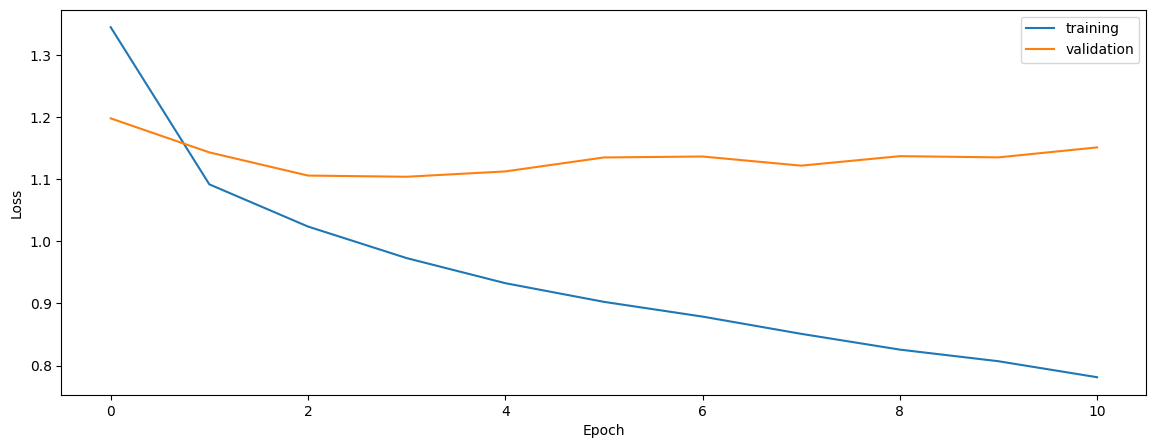

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6304376560460329
0.5595613185848713
0.5751067533901841


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5879600158634926
0.5364115818518389
0.5923400168087406


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5904709400424331
0.5499717673630717
0.5977314158395787


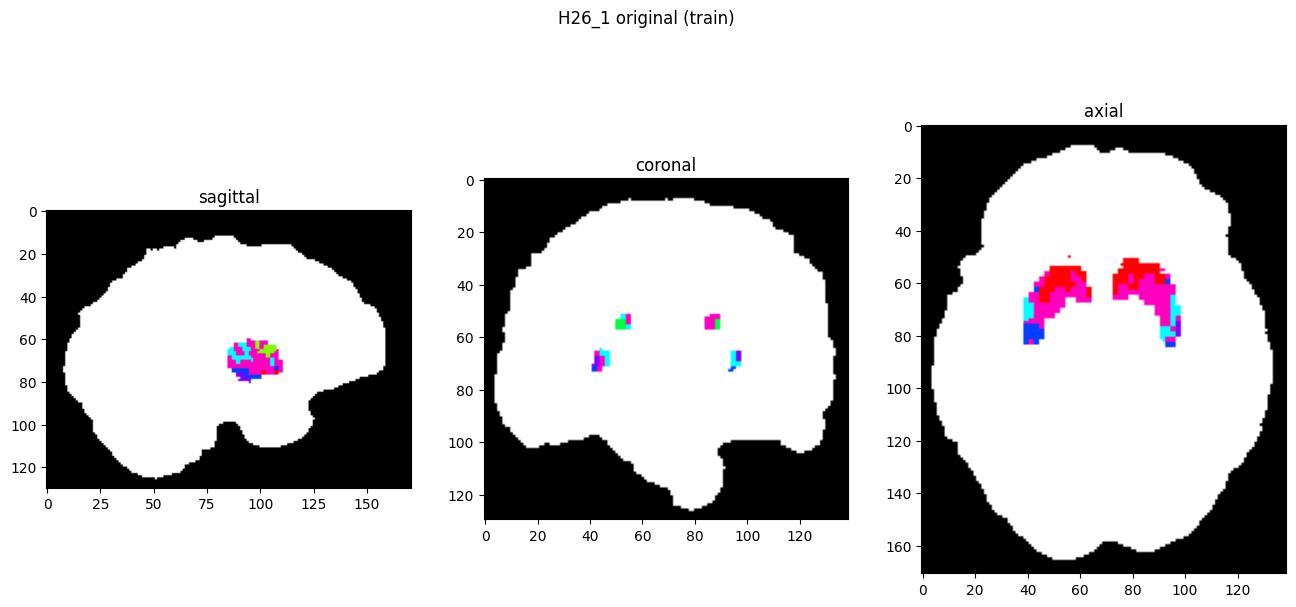

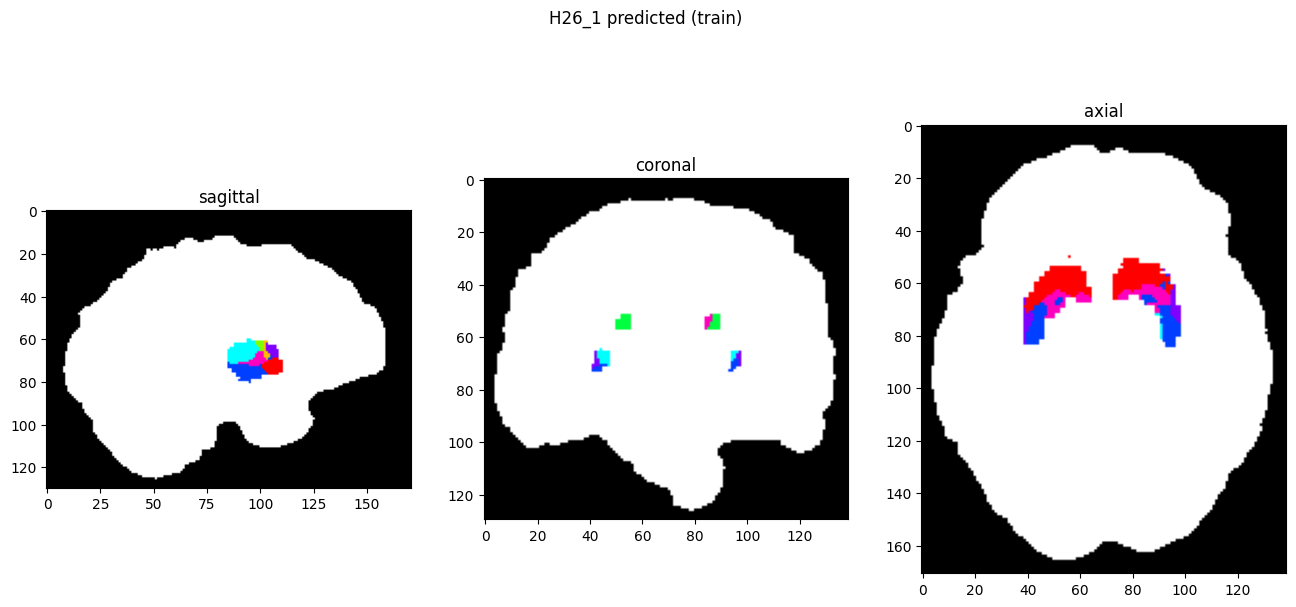

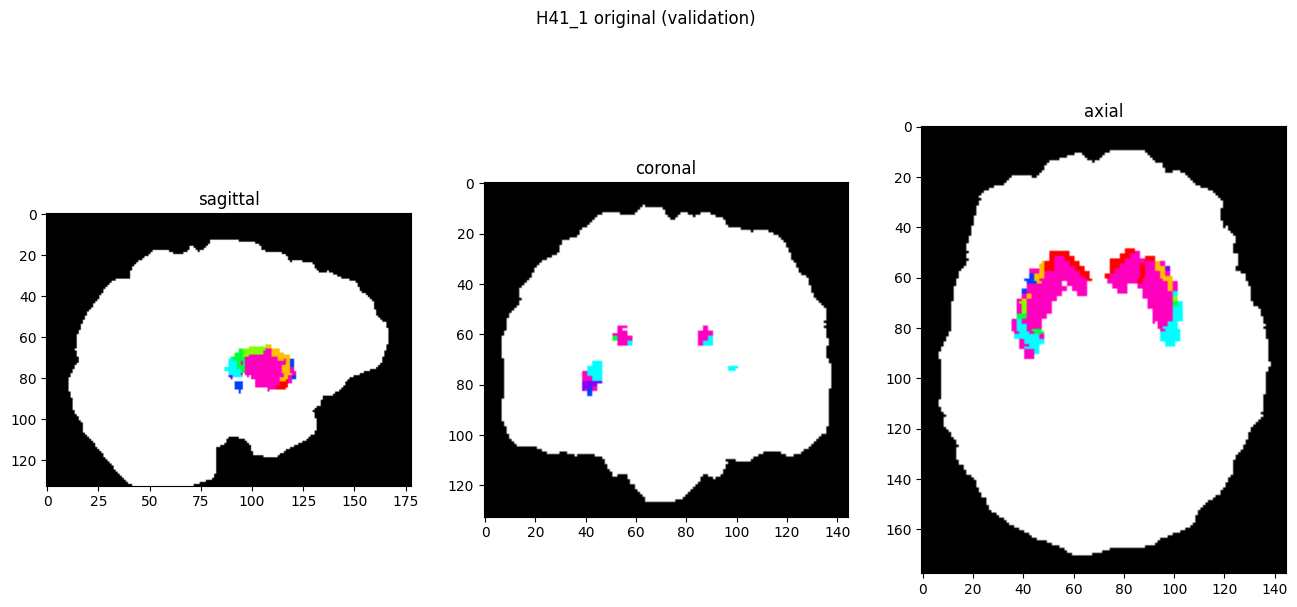

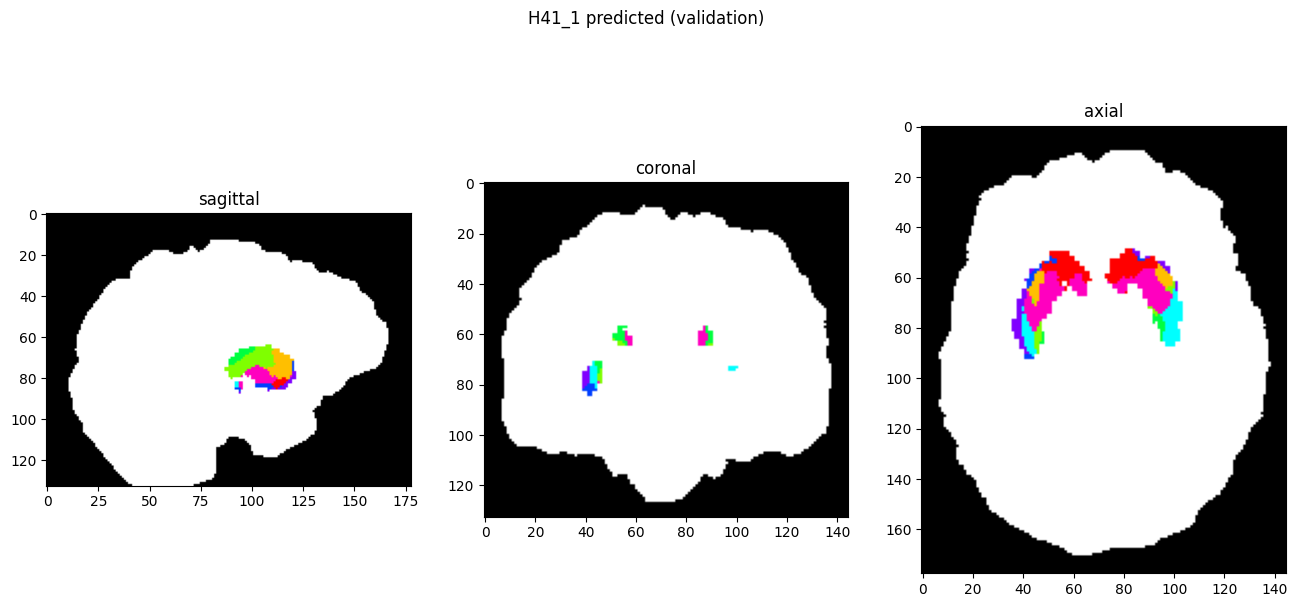

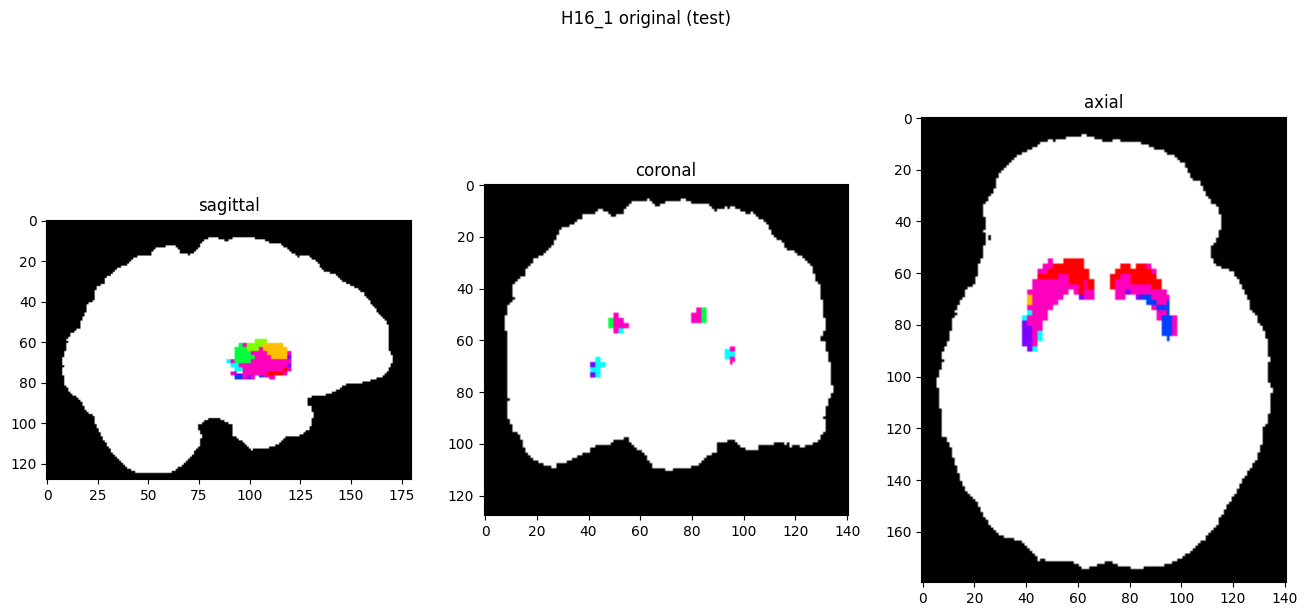

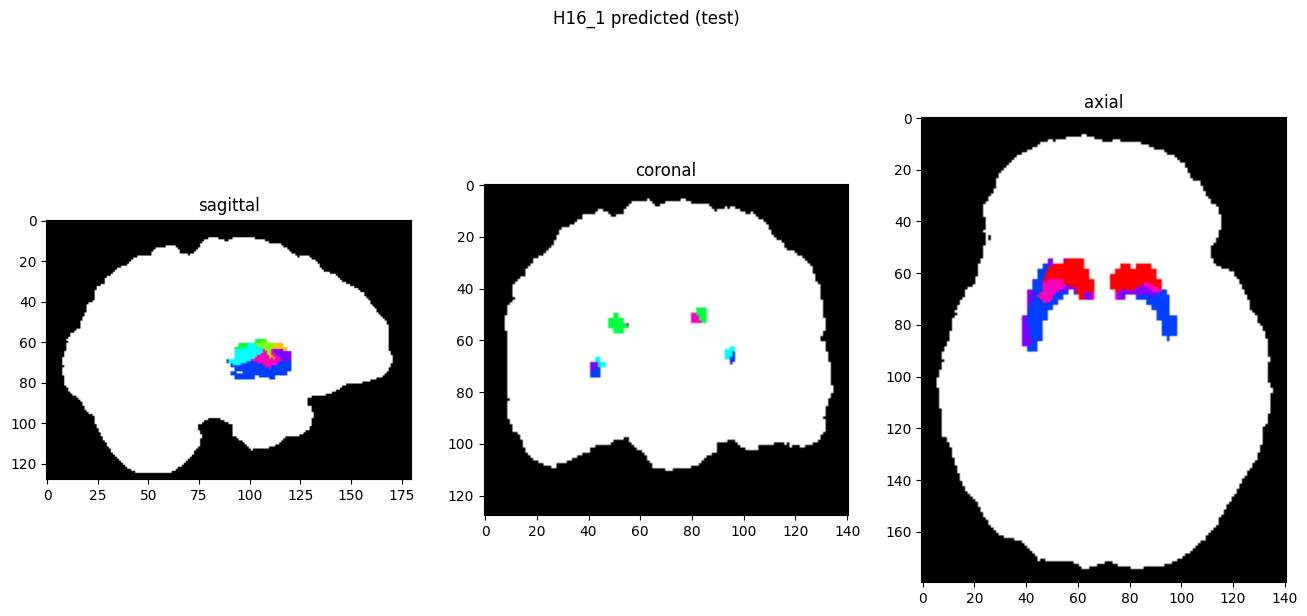

In [10]:
showResults(model, gen, threshold=0)